<a href="https://colab.research.google.com/github/ougrid/my-knowledge-resource/blob/master/Image_Captioning_Using_Attention%5Bfuse%5D_Train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Fuse CNN - Train


In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import matplotlib.pyplot as plt
%matplotlib inline
import cv2
from tqdm import tqdm

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path = '/content/drive/MyDrive/PHD/Image Captioning Colab/Dataset/Flickr8k'
text_path = path+'/Flickr8k_text'
images_path = path+'/Flickr8k_Dataset'
captions_path = text_path+'/Flickr8k.token.txt'
train_path = text_path+'/Flickr_8k.trainImages.txt'
val_path = text_path+'/Flickr_8k.devImages.txt'
test_path = text_path+'/Flickr_8k.testImages.txt'
images_dir = os.listdir(path+'/Flickr8k_Dataset')

In [ ]:
def show_image(img_path):
    k = cv2.imread(path+'/Images/'+img_path)
    k = cv2.cvtColor(k,cv2.COLOR_BGR2RGB)
    plt.axis('off')
    plt.imshow(k)

In [ ]:
captions = open(captions_path, 'r').read().split("\n")
x_train = open(train_path, 'r').read().split("\n")
x_val = open(val_path, 'r').read().split("\n")
x_test = open(test_path, 'r').read().split("\n")

In [ ]:
tokens = {}

for ix in range(len(captions)-1):
    temp = captions[ix].split("#")
    if temp[0] in tokens:
        tokens[temp[0]].append(temp[1][2:])
    else:
        tokens[temp[0]] = [temp[1][2:]]

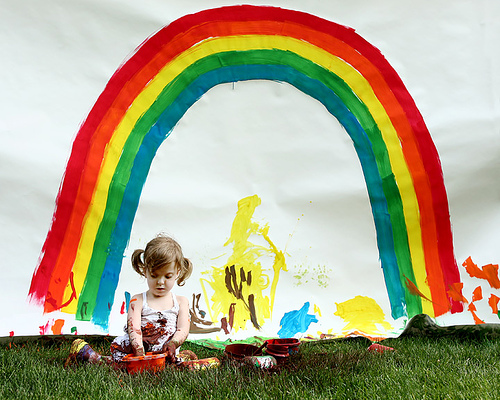

A little girl covered in paint sits in front of a painted rainbow with her hands in a bowl .
A little girl is sitting in front of a large painted rainbow .
A small girl in the grass plays with fingerpaints in front of a white canvas with a rainbow on it .
There is a girl with pigtails sitting in front of a rainbow painting .
Young girl with pigtails painting outside in the grass .


In [ ]:
temp = captions[10].split("#")
from IPython.display import Image, display
z = Image(filename=images_path+'/'+temp[0])
display(z)

for ix in range(len(tokens[temp[0]])):
    print(tokens[temp[0]][ix])

# Preparing Caption Dataset
We need to create a vocabulary for all the words that are present in the image caption dataset. Once we have that the next step is to create our caption vectors. To do that we first choose
-Length of the caption
-Frequency of the words
We want to pad the sentences upto the max length (213) with <pad> token. Once that is done, we decide the threshold of the frequency of the words. If the word has lower count than some threshold it is replaced by <unk> keyword. Therefore each caption is supposed to look like -
<start> A little girl is sitting in <unk> front of a large <unk> rainbow . <end> <pad> <pad> <pad> .... where we assume frequency of front and painted is less than the threshold.
Once we have done that the next step is to tokenize the vectors. This is nothing but just substituting the words with some number. So little could be represented by 43. Note keep <pad> as 0 for implementation purposes
Therefore, captions fed to the model must be an Int tensor of dimension N, L where L is the padded length. caption lengths fed to the model must be an Int tensor of dimension N.

# Observations
-Over 6% captions have length > 100. For the purpose of learning we dont tinker with that
-Over 42% words have a frequency of 1. Technically we should set a threshold but the score could be severely affected if we use <unk>. Thus we dont make those changes

In [ ]:
start = '<start> '
end = ' <end>'
cap_train = []
for img in x_train:
    if img == '':
        continue
    caption = [start + text + end for text in tokens[img]]
    cap_train +=  caption
cap_val = []

for img in x_val:
    if img == '':
        continue
    caption = [start + text + end for text in tokens[img]]
    cap_val +=  caption
cap_test = []

for img in x_test:
    if img == '':
        continue
    caption = [start + text + end for text in tokens[img]]
    cap_test +=  caption

In [ ]:
all_captions = cap_train +cap_val + cap_test
all_captions[:5]

['<start> A black dog is running after a white dog in the snow . <end>',
 '<start> Black dog chasing brown dog through snow <end>',
 '<start> Two dogs chase each other across the snowy ground . <end>',
 '<start> Two dogs play together in the snow . <end>',
 '<start> Two dogs running through a low lying body of water . <end>']

# Creating Vocabulary

In [ ]:
from collections import Counter
sent = [k.split(' ') for k in all_captions]
sentences = [y for x in sent for y in x]

count_words = Counter(sentences)

In [ ]:
min_threshold = 0
words = [w for w in count_words.keys() if count_words[w] > min_threshold]
#unk_words = [w for w in count_words.keys() if count_words[w] < min_threshold]
word_map = {k: v + 1 for v, k in enumerate(words)}
word_map['<unk>'] = len(word_map) + 3
word_map['<start>'] = len(word_map) + 1
word_map['<end>'] = len(word_map) + 2
word_map['<pad>'] = 0

In [ ]:
def word2ind(x):
    if x in word_map.keys():
        return word_map[x]
    else:
        return word_map['<unk>']

Token train is the list of captions that will be used for training

In [ ]:
max_len = 40
tokenized_dataset = {}
splits = ['train','val','test']
caption_split = [cap_train, cap_val,cap_test]
for i,split in enumerate(splits):
    token_caption = []
    token_caption_len = []
    for cap in caption_split[i]:
        s = list(map(word2ind,cap.split(' ')))
        token_caption.append(list(s) + [word_map['<pad>']]*(max_len-len(s)))
        token_caption_len.append(len(cap.split(' ')))
    tokenized_dataset[split] = [token_caption,token_caption_len]

# Creating Pytorch Dataset

In [ ]:
import torch
from torch.utils.data import Dataset

In [ ]:
def readImg(x):
    img = cv2.imread(x)
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (256,256))
    return img

In [ ]:
class CaptionDataset(Dataset):
    def __init__(self,img_dir,img_list,captions,split,transform=None):
        self.img_dir = img_dir
        self.img_list = img_list
        self.split = split
        self.captions = captions[0]
        self.captions_length = captions[1]
        self.transform = transform
        self.cpi = 5

    def __len__(self):
        return len(self.captions)

    def __getitem__(self, i):
        # Remember, the Nth caption corresponds to the (N // captions_per_image)th image
        img = readImg(self.img_dir+'/'+self.img_list[i//self.cpi])
        img = torch.FloatTensor(img / 255.)
#         img = img/255.0
        if self.transform is not None:
            img = img.permute((2,0,1))
            img = self.transform(img)

        caption = torch.LongTensor(self.captions[i])

        caplen = torch.LongTensor([self.captions_length[i]])

        if self.split == 'TRAIN':
            return img, caption, caplen
        else:
            # For validation of testing, also return all 'captions_per_image' captions to find BLEU-4 score
            all_captions = torch.LongTensor(
                self.captions[((i // self.cpi) * self.cpi):(((i // self.cpi) * self.cpi) + self.cpi)])
            return img, caption, caplen, all_captions

In [ ]:
import torchvision.transforms as transforms
from torch.utils.data import TensorDataset, DataLoader, Dataset

transforms_train = transforms.Compose([
#     transforms.ToPILImage(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                            std=[0.229, 0.224, 0.225])
])
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
train_data = CaptionDataset(images_path, x_train, tokenized_dataset['train'],'TRAIN',transform=transforms.Compose([normalize]))
val_data = CaptionDataset(images_path, x_val, tokenized_dataset['val'],'VAL',transform=transforms.Compose([normalize]))
test_data = CaptionDataset(images_path, x_test, tokenized_dataset['test'],'TEST',transform=transforms.Compose([normalize]))

In [ ]:
batch = 32
train_loader = DataLoader(train_data,batch_size=batch, shuffle=True, pin_memory=True)
val_loader = DataLoader(val_data,batch_size=batch, shuffle=True, pin_memory=True)
test_loader = DataLoader(test_data,batch_size=1, shuffle=True, pin_memory=True)

# Model

In [ ]:
!pip install efficientnet_pytorch

  Preparing metadata (setup.py) ... done
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
  Using cached 

## Encoder

We now define the model architecture. In very crude terms it is a encoder decoder architecture where encoder will encode the image features and the decoder will use those features to extract the caption. The encoder returns a tensor of size 2048x14x14. This is then the input to our decoder based LSTM.

In [ ]:
from torch import nn
import torchvision

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# import torch
# import torch.nn as nn
# import torchvision.models as models
# from efficientnet_pytorch import EfficientNet
# from torchvision.models import resnet101, ResNet101_Weights
# class Encoder(nn.Module):
#     def __init__(self, encoded_image_size=14, fine_tune=True):
#         super(Encoder, self).__init__()
#         self.enc_size = encoded_image_size
#         self.efficientnet = EfficientNet.from_pretrained('efficientnet-b0')

#         # Initialize ResNet-101 as a class attribute
#         self.resnet101 = resnet101(weights=ResNet101_Weights.IMAGENET1K_V1)
#         self.resnet101.fc = nn.Identity()  # Removing the fully connected layer
#         # self.resnet101.avgpool = nn.Identity()  # Replacing avgpool with Identity

#         self.efficientnet._fc = nn.Identity()  # Removing EfficientNet's classifier layer
#         self.pool = nn.AdaptiveAvgPool2d(self.enc_size)

#         self.fine_tune(fine_tune)

#     def forward(self, x):
#         # Feature extraction with EfficientNet-b0
#         bp_eff = self.efficientnet.extract_features(x)
#         ap_eff = self.pool(bp_eff)  # This should work as intended.

#         # Feature extraction with ResNet-101
#         bp_res = self.resnet101(x)  # Ensure this is 4D: [batch_size, num_channels, H, W]
#         ap_res = self.pool(bp_res)  # Directly apply pooling to the 4D tensor

#         # Concatenate features
#         concat_features = torch.cat([ap_eff, ap_res], dim=1)  # Concatenate along the channel dimension
#         out = concat_features.permute(0, 2, 3, 1)  # Final rearrangement
#         return out

#     def fine_tune(self, fine_tune=True):
#         if not fine_tune:
#             for p in self.efficientnet.parameters():
#                 p.requires_grad = False
#             for p in self.resnet101.parameters():
#                 p.requires_grad = False
#         else:
#             # Fine-tuning last blocks of EfficientNet
#             for name, param in self.efficientnet.named_parameters():
#                 # Extract block index and fine-tune from a specific block onwards, e.g., block 15
#                 parts = name.split('.')
#                 if parts[0] == '_blocks' and len(parts) > 1:
#                     block_index = int(parts[1])
#                     if block_index >= 15:  # Fine-tune from this block onwards
#                         param.requires_grad = True

#             # Fine-tuning last layers of ResNet-101
#             for name, param in self.resnet101.named_parameters():
#                 if 'layer4' in name:
#                     param.requires_grad = True



In [ ]:
from efficientnet_pytorch import EfficientNet

class Encoder(nn.Module):

    def __init__(self,encoded_image_size=14,fine_tune=True):
        super(Encoder,self).__init__()
        self.enc_size = encoded_image_size

        # ResNet
        resnet = torchvision.models.resnet101(pretrained=True)
        modules = list(resnet.children())[:-2]
        self.resnet_model = nn.Sequential(*modules)

        # EfficientNet
        self.effnet_model = EfficientNet.from_pretrained('efficientnet-b0')
        # Removing the last linear layer isn't straightforward as with resnet because the EfficientNet isn't sequential model.
        # But the forward method of EfficientNet takes an argument which we can use to get the required output.
        # The efficientnet_pytorch documentation refers to this as 'Extract features'

        self.pool = nn.AdaptiveAvgPool2d(self.enc_size)

        self.fine_tune(fine_tune)

    def forward(self,x):
        # Pass image through both models
        resnet_out = self.resnet_model(x) # (batch,2048,img/32,img/32)
        effnet_out = self.effnet_model.extract_features(x) # (batch,1280,img/32,img/32) for EfficientNet-b0

        # Pool the outputs
        resnet_out = self.pool(resnet_out) # (batch, 2048,enc_img_size,enc_img_size)
        effnet_out = self.pool(effnet_out) # (batch, 1280,enc_img_size,enc_img_size)

        # Concatenate along the channel dimension
        out = torch.cat((resnet_out, effnet_out), dim=1) # (batch, 2048+1280, enc_img_size, enc_img_size)
        out = out.permute(0,2,3,1) #(batch,enc_img_size,enc_img_size,2048+1280)
        return out

    def fine_tune(self,fine_tune=True):
        for p in self.resnet_model.parameters():
            p.requires_grad = False
        for p in self.effnet_model.parameters():
            p.requires_grad = False
        # If we fine tune then we only do with conv layers through blocks 2 to 4
        if fine_tune:
            for c in list(self.resnet_model.children())[5:]:
                for p in c.parameters():
                    p.requires_grad = True
            # For EfficientNet, we allow all layers to be fine-tuned. Adjust this part based on your specific requirements.
            for p in self.effnet_model.parameters():
                p.requires_grad = True


Our decoder consists of a long list of LSTMs. The Decoder's job is to look at the encoded image and generate a caption word by word.
In a typical setting without Attention, you could simply average the encoded image across all pixels. You could then feed this, with or without a linear transformation, into the Decoder as its first hidden state and generate the caption. Each predicted word is used to generate the next word.

# Attention

In [ ]:
class Attention(nn.Module):
    def __init__(self,encoder_dim,decoder_dim,attention_dim):
        """
        encoder_dim : size of encoded images
        decoder_dim : size of decoder RNNs
        attention_dim : size of the attention network
        """
        super(Attention,self).__init__()
        self.encoder_att = nn.Linear(encoder_dim,attention_dim)
        self.decoder_att = nn.Linear(decoder_dim,attention_dim)
        self.full_att = nn.Linear(attention_dim,1)#linear layer to calculate the value to be softmaxed
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)# softmax layer to calculate the weights

    def forward(self,encoder_out,decoder_hidden):
        """
        :param encoder_out: encoded images, a tensor of dimension (batch_size, num_pixels, encoder_dim)
        :param decoder_hidden: previous decoder output, a tensor of dimension (batch_size, decoder_dim)
        :return: attention weighted encoding, weights
        """
        att1 = self.encoder_att(encoder_out)
        att2 = self.decoder_att(decoder_hidden)
        att_full = self.full_att(att1+att2.unsqueeze(1)).squeeze(2) #(batch,num_pixels)
        alpha = self.softmax(att_full) #(batch,num_pixels)
        attention_weighted_encoding = (encoder_out* alpha.unsqueeze(2)).sum(dim=1) #(batch_size,encoder_dim)

        return attention_weighted_encoding, alpha

# Decoder

In [ ]:
# class Decoder(nn.Module):
#     def __init__(self, attention_dim, embed_dim, decoder_dim, vocab_size, encoder_dim = 3328, dropout = 0.5):
#         super(Decoder,self).__init__()
#         self.encoder_dim = encoder_dim
#         self.decoder_dim = decoder_dim
#         self.attention_dim = attention_dim
#         self.embed_dim = embed_dim
#         self.vocab_size = vocab_size
# #         self.dropout = dropout

#         self.attention = Attention(encoder_dim,decoder_dim,attention_dim)

#         self.embedding = nn.Embedding(vocab_size,embed_dim) #embedding layer
#         self.dropout = nn.Dropout(p=dropout)
#         self.decode_step = nn.LSTMCell(embed_dim + encoder_dim, decoder_dim, bias=True)  # decoding LSTMCell
#         self.init_h = nn.Linear(encoder_dim, decoder_dim) #linear layer to find initial hidden layer in LSTM
#         self.init_c = nn.Linear(encoder_dim, decoder_dim) #linear layer to find initial cell layer in LSTM
#         self.f_beta = nn.Linear(decoder_dim, encoder_dim) #linear layer to find create a sigmoid-activated gate

#         self.sigmoid = nn.Sigmoid()
#         self.fc = nn.Linear(decoder_dim, vocab_size) #linear layer to find scores over vocabulary
#         self.init_weights()

#     def init_weights(self):
#         """
#         Initialization over uniform distribution
#         """
#         self.embedding.weight.data.uniform_(-0.1,0.1)
#         self.fc.bias.data.fill_(0)
#         self.fc.weight.data.uniform_(-0.1,0.1)

#     def load_pretrained_embeddings(self,embedding):
#         """
#         Loads pretrained embeddings
#         """
#         self.embedding.weight = nn.Parameter(embedding)
#     def fine_tune_embeddings(self,fine_tune=True):
#         """
#         Unless using pretrained embeddings, keep it true
#         """
#         for p in self.embedding.parameters():
#             p.requires_grad=fine_tune

#     def init_hidden_state(self,encoder_out):
#         """
#         Creates initial hidden and cell state of the LSTM based on the encoded images.
#         :encoder_out : encoded images, a tensor of dimension(batch_size, num_of_pixels,encoder_dim)
#         :return hidden and cell state
#         """
#         mean_encoder_out = encoder_out.mean(dim=1)
#         h = self.init_h(mean_encoder_out) #(batch_size,decoder_dim) output
#         c = self.init_c(mean_encoder_out)
#         return h,c

#     def forward(self, encoder_out, encoded_captions, caption_lengths):
#         """
#         Forward propagation.
#         :param encoder_out: encoded images, a tensor of dimension (batch_size, enc_image_size, enc_image_size, encoder_dim)
#         :param encoded_captions: encoded captions, a tensor of dimension (batch_size, max_caption_length)
#         :param caption_lengths: caption lengths, a tensor of dimension (batch_size, 1)
#         :return: scores for vocabulary, sorted encoded captions, decode lengths, weights, sort indices
#         """

#         batch_size = encoder_out.size(0)
#         encoder_dim = encoder_out.size(-1)
#         vocab_size = self.vocab_size

#         # Flatten image
#         encoder_out = encoder_out.view(batch_size, -1, encoder_dim)  # (batch_size, num_pixels, encoder_dim)
#         num_pixels = encoder_out.size(1)

#         # Sort input data by decreasing lengths; why? apparent below
#         caption_lengths, sort_ind = caption_lengths.squeeze(1).sort(dim=0, descending=True)
#         encoder_out = encoder_out[sort_ind]
#         encoded_captions = encoded_captions[sort_ind]

#         # Embedding
#         embeddings = self.embedding(encoded_captions)  # (batch_size, max_caption_length, embed_dim)

#         # Initialize LSTM state
#         h, c = self.init_hidden_state(encoder_out)  # (batch_size, decoder_dim)

#         # We won't decode at the <end> position, since we've finished generating as soon as we generate <end>
#         # So, decoding lengths are actual lengths - 1
#         decode_lengths = (caption_lengths - 1).tolist()

#         # Create tensors to hold word predicion scores and alphas
#         predictions = torch.zeros(batch_size, max(decode_lengths), vocab_size).to(device)
#         alphas = torch.zeros(batch_size, max(decode_lengths), num_pixels).to(device)

#         # At each time-step, decode by
#         # attention-weighing the encoder's output based on the decoder's previous hidden state output
#         # then generate a new word in the decoder with the previous word and the attention weighted encoding
#         for t in range(max(decode_lengths)):
#             batch_size_t = sum([l > t for l in decode_lengths])
#             attention_weighted_encoding, alpha = self.attention(encoder_out[:batch_size_t],
#                                                                 h[:batch_size_t])
#             gate = self.sigmoid(self.f_beta(h[:batch_size_t]))  # gating scalar, (batch_size_t, encoder_dim)
#             attention_weighted_encoding = gate * attention_weighted_encoding
#             h, c = self.decode_step(
#                 torch.cat([embeddings[:batch_size_t, t, :], attention_weighted_encoding], dim=1),
#                 (h[:batch_size_t], c[:batch_size_t]))  # (batch_size_t, decoder_dim)
#             preds = self.fc(self.dropout(h))  # (batch_size_t, vocab_size)
#             predictions[:batch_size_t, t, :] = preds
#             alphas[:batch_size_t, t, :] = alpha

#         return predictions, encoded_captions, decode_lengths, alphas, sort_ind

In [ ]:
class Decoder(nn.Module):
    def __init__(self,attention_dim,embed_dim, decoder_dim, vocab_size,encoder_dim = 3328, dropout = 0.5):
        super(Decoder,self).__init__()
        self.encoder_dim = encoder_dim
        self.decoder_dim = decoder_dim
        self.attention_dim = attention_dim
        self.embed_dim = embed_dim
        self.vocab_size = vocab_size
#         self.dropout = dropout

        self.attention = Attention(encoder_dim,decoder_dim,attention_dim)

        self.embedding = nn.Embedding(vocab_size,embed_dim) #embedding layer
        self.dropout = nn.Dropout(p=dropout)
        self.decode_step = nn.LSTMCell(embed_dim + encoder_dim, decoder_dim, bias=True)  # decoding LSTMCell
        self.init_h = nn.Linear(encoder_dim, decoder_dim) #linear layer to find initial hidden layer in LSTM
        self.init_c = nn.Linear(encoder_dim, decoder_dim) #linear layer to find initial cell layer in LSTM
        self.f_beta = nn.Linear(decoder_dim, encoder_dim) #linear layer to find create a sigmoid-activated gate

        self.sigmoid = nn.Sigmoid()
        self.fc = nn.Linear(decoder_dim, vocab_size) #linear layer to find scores over vocabulary
        self.init_weights()

    def init_weights(self):
        """
        Initialization over uniform distribution
        """
        self.embedding.weight.data.uniform_(-0.1,0.1)
        self.fc.bias.data.fill_(0)
        self.fc.weight.data.uniform_(-0.1,0.1)

    def load_pretrained_embeddings(self,embedding):
        """
        Loads pretrained embeddings
        """
        self.embedding.weight = nn.Parameter(embedding)
    def fine_tune_embeddings(self,fine_tune=True):
        """
        Unless using pretrained embeddings, keep it true
        """
        for p in self.embedding.parameters():
            p.requires_grad=fine_tune

    def init_hidden_state(self,encoder_out):
        """
        Creates initial hidden and cell state of the LSTM based on the encoded images.
        :encoder_out : encoded images, a tensor of dimension(batch_size, num_of_pixels,encoder_dim)
        :return hidden and cell state
        """
        mean_encoder_out = encoder_out.mean(dim=1)
        h = self.init_h(mean_encoder_out) #(batch_size,decoder_dim) output
        c = self.init_c(mean_encoder_out)
        return h,c

    def forward(self, encoder_out, encoded_captions, caption_lengths):
        """
        Forward propagation.
        :param encoder_out: encoded images, a tensor of dimension (batch_size, enc_image_size, enc_image_size, encoder_dim)
        :param encoded_captions: encoded captions, a tensor of dimension (batch_size, max_caption_length)
        :param caption_lengths: caption lengths, a tensor of dimension (batch_size, 1)
        :return: scores for vocabulary, sorted encoded captions, decode lengths, weights, sort indices
        """

        batch_size = encoder_out.size(0)
        encoder_dim = encoder_out.size(-1)
        vocab_size = self.vocab_size

        # Flatten image
        encoder_out = encoder_out.view(batch_size, -1, encoder_dim)  # (batch_size, num_pixels, encoder_dim)
        num_pixels = encoder_out.size(1)

        # Sort input data by decreasing lengths; why? apparent below
        caption_lengths, sort_ind = caption_lengths.squeeze(1).sort(dim=0, descending=True)
        encoder_out = encoder_out[sort_ind]
        encoded_captions = encoded_captions[sort_ind]

        # Embedding
        embeddings = self.embedding(encoded_captions)  # (batch_size, max_caption_length, embed_dim)

        # Initialize LSTM state
        h, c = self.init_hidden_state(encoder_out)  # (batch_size, decoder_dim)

        # We won't decode at the <end> position, since we've finished generating as soon as we generate <end>
        # So, decoding lengths are actual lengths - 1
        decode_lengths = (caption_lengths - 1).tolist()

        # Create tensors to hold word predicion scores and alphas
        predictions = torch.zeros(batch_size, max(decode_lengths), vocab_size).to(device)
        alphas = torch.zeros(batch_size, max(decode_lengths), num_pixels).to(device)

        # At each time-step, decode by
        # attention-weighing the encoder's output based on the decoder's previous hidden state output
        # then generate a new word in the decoder with the previous word and the attention weighted encoding
        for t in range(max(decode_lengths)):
            batch_size_t = sum([l > t for l in decode_lengths])
            attention_weighted_encoding, alpha = self.attention(encoder_out[:batch_size_t],
                                                                h[:batch_size_t])
            gate = self.sigmoid(self.f_beta(h[:batch_size_t]))  # gating scalar, (batch_size_t, encoder_dim)
            attention_weighted_encoding = gate * attention_weighted_encoding
            h, c = self.decode_step(
                torch.cat([embeddings[:batch_size_t, t, :], attention_weighted_encoding], dim=1),
                (h[:batch_size_t], c[:batch_size_t]))  # (batch_size_t, decoder_dim)
            preds = self.fc(self.dropout(h))  # (batch_size_t, vocab_size)
            predictions[:batch_size_t, t, :] = preds
            alphas[:batch_size_t, t, :] = alpha

        return predictions, encoded_captions, decode_lengths, alphas, sort_ind

# Creating Util functions

In [ ]:
def init_embeddings(embeddings):
    """
    Fills embeddings with uniform information
    """
    bias = np.sqrt(3.0/embeddings.size(1))
    torch.nn.init.uniform_(embeddings,-bias,bias)

def load_embeddings(emb_file,word_map):
    """
    Creates an embedding tensor for the specified word map, for loading into the model.
    :param emb_file: file containing embeddings (stored in GloVe format)
    :param word_map: word map
    :return: embeddings in the same order as the words in the word map, dimension of embeddings
    """
    with open(emb_file,'r') as f:
        emb_dim = len(f.readline().split(' ')) - 1
    vocab = set(word_map.keys())

    embeddings = torch.FloatTensor(len(vocab), emb_dim)
    init_embeddings(embeddings)

    print("Loading embeddings")
    for line in open(emb_file,'r'):
        line = line.split(' ')

        emb_words = line[0]
        embedding = list(map(lambda t: float(t), filter(lambda n: n and not n.isspace(), line[1:])))

        if emb_file not in vocab:
            continue
        embeddings[word_map[emb_word]] = torch.FloatTensor(embedding)
    return embeddings, emb_dim

def clip_gradient(optimizer, grad_clip):
    """
    Clips gradients during backprop
    """
    for group in optimizer.param_groups:
        for param in group['params']:
            if param.grad is not None:
                param.grad.data.clamp_(-grad_clip,grad_clip)
def save_checkpoint(data_name, epoch, epochs_since_improvement, encoder, decoder, encoder_optimizer, decoder_optimizer,
                    bleu4, is_best):
    """
    Saves model checkpoint.
    :param data_name: base name of processed dataset
    :param epoch: epoch number
    :param epochs_since_improvement: number of epochs since last improvement in BLEU-4 score
    :param encoder: encoder model
    :param decoder: decoder model
    :param encoder_optimizer: optimizer to update encoder's weights, if fine-tuning
    :param decoder_optimizer: optimizer to update decoder's weights
    :param bleu4: validation BLEU-4 score for this epoch
    :param is_best: is this checkpoint the best so far?
    """
    state = {'epoch': epoch,
             'epochs_since_improvement': epochs_since_improvement,
             'bleu-4': bleu4,
             'encoder_state_dict': encoder.state_dict(),
             'decoder_state_dict': decoder.state_dict(),
             'encoder_optimizer_state_dict': encoder_optimizer.state_dict() if encoder_optimizer is not None else None,
             'decoder_optimizer_state_dict': decoder_optimizer.state_dict() if decoder_optimizer is not None else None}
    filename = 'checkpoint_' + data_name + '.pth.tar'
    torch.save(state, filename)
    # If this checkpoint is the best so far, store a copy so it doesn't get overwritten by a worse checkpoint
    if is_best:
        torch.save(state, 'BEST_' + filename)


class AverageMeter(object):
    """
    Keeps track of most recent, average, sum, and count of a metric.
    """

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def adjust_learning_rate(optimizer, shrink_factor):
    """
    Shrinks learning rate by a specified factor.
    :param optimizer: optimizer whose learning rate must be shrunk.
    :param shrink_factor: factor in interval (0, 1) to multiply learning rate with.
    """

    print("\nDECAYING learning rate.")
    for param_group in optimizer.param_groups:
        param_group['lr'] = param_group['lr'] * shrink_factor
    print("The new learning rate is %f\n" % (optimizer.param_groups[0]['lr'],))


def accuracy(scores, targets, k):
    """
    Computes top-k accuracy, from predicted and true labels.
    :param scores: scores from the model
    :param targets: true labels
    :param k: k in top-k accuracy
    :return: top-k accuracy
    """

    batch_size = targets.size(0)
    _, ind = scores.topk(k, 1, True, True)
    correct = ind.eq(targets.view(-1, 1).expand_as(ind))
    correct_total = correct.view(-1).float().sum()  # 0D tensor
    return correct_total.item() * (100.0 / batch_size)

# Training the Model

We now set the variables and with all our pieces intact we can start training

In [ ]:
# Model Parameters
emb_dim = 512
attention_dim = 512
decoder_dim = 512
dropout = 0.5
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# cudnn.benchmark = True #set to True if inputs to model are fixed size

#Training Parameters
start_epoch = 0
epochs = 50
epochs_since_improvement = 0
batch_size = 3
encoder_lr = 1e-4
decoder_lr = 4e-4
grad_clip = 5.0
alpha_c = 1.0 #will be used in doubly attention loss part
best_bleu4 = 0
print_freq = 100
fine_tune_encoder = False
checkpoint = None

In [ ]:
decoder = Decoder(attention_dim=attention_dim,
                 embed_dim = emb_dim,
                 decoder_dim=decoder_dim,
                 vocab_size = len(word_map)+2,
                 dropout=dropout)
optim_decoder = torch.optim.Adam(params=filter(lambda p: p.requires_grad, decoder.parameters()),
                                             lr=decoder_lr)
encoder = Encoder()

optim_encoder = torch.optim.Adam(params=filter(lambda p: p.requires_grad, encoder.parameters()),
                                             lr=encoder_lr) if fine_tune_encoder else None
if checkpoint:
    checkpoint = torch.load(checkpoint)
    decoder.load_state_dict(checkpoint['decoder_state_dict'])
    encoder.load_state_dict(checkpoint['encoder_state_dict'])
    optim_decoder.load_state_dict(checkpoint['decoder_optimizer_state_dict'])
    optim_encoder.load_state_dict(checkpoint['encoder_optimizer_state_dict'])
    start_epoch = checkpoint['epoch'] + 1
    epochs_since_improvement = checkpoint['epochs_since_improvement']
    best_bleu4 = checkpoint['bleu-4']
    if fine_tune_encoder and encoder:
        encoder.fine_tune(fine_tune_encoder)
        optim_encoder = torch.optim.Adam(params=filter(lambda p: p.requires_grad, encoder.parameters()),
                                             lr=encoder_lr)
decoder.to(device)
encoder.to(device)
criterion = nn.CrossEntropyLoss().to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to /root/.cache/torch/hub/checkpoints/resnet101-63fe2227.pth
100%|██████████| 171M/171M [00:00<00:00, 190MB/s]
Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b0-355c32eb.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b0-355c32eb.pth
100%|██

Loaded pretrained weights for efficientnet-b0


# Training Loop

In [ ]:
train_losses = []
val_losses = []

In [ ]:
from torch.nn.utils.rnn import pack_padded_sequence
import time
def train(train_loader,encoder, decoder, criterion, optim_encoder, optim_decoder,epoch):
    decoder.train()
    encoder.train()

    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    top5acc = AverageMeter()

    start = time.time()

    for i , (imgs,caps,caplens) in enumerate(train_loader):
        data_time.update(time.time()-start)
        imgs = imgs.to(device)
        caps = caps.to(device)
        caplens = caplens.to(device)

        #Forward Prop

        imgs = encoder(imgs)
        scores,cap_sorted, decode_lengths, alphas, sort_ind = decoder(imgs,caps,caplens)

        targets = cap_sorted[:,1:]

        # Remove timesteps that we didn't decode at, or are pads
        # pack_padded_sequence is an easy trick to do this
        scores = pack_padded_sequence(scores, decode_lengths, batch_first=True).data
        targets = pack_padded_sequence(targets, decode_lengths, batch_first=True).data

        loss = criterion(scores,targets)

        #Add doubly stochastic attention regularization
        loss += alpha_c * ((1. - alphas.sum(dim=1)) ** 2).mean()

        #Backprop
        optim_decoder.zero_grad()
        if optim_encoder:
            optim_encoder.zero_grad()
        loss.backward()

        if grad_clip:
            clip_gradient(optim_decoder,grad_clip)
            if optim_encoder:
                clip_gradient(optim_encoder,grad_clip)

        #Update weights
        optim_decoder.step()
        if optim_encoder:
            optim_encoder.step()

        top5 = accuracy(scores, targets, 5)
        losses.update(loss.item(), sum(decode_lengths))
        top5acc.update(top5, sum(decode_lengths))
        batch_time.update(time.time() - start)

        start = time.time()

        # Print status
        if i % print_freq == 0:
            print('Epoch: [{0}][{1}/{2}]\t'
                  'Batch Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                  'Data Load Time {data_time.val:.3f} ({data_time.avg:.3f})\t'
                  'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
                  'Top-5 Accuracy {top5.val:.3f} ({top5.avg:.3f})'.format(epoch, i, len(train_loader),
                                                                          batch_time=batch_time,
                                                                          data_time=data_time, loss=losses,
                                                                          top5=top5acc))
    return losses.avg

# Validation Loop

In [ ]:
from nltk.translate.bleu_score import corpus_bleu
def validate(val_loader, encoder,decoder, criterion):
    decoder.eval()
    if encoder:
        encoder.eval()
    batch_time = AverageMeter()
    losses = AverageMeter()
    top5accs = AverageMeter()

    start = time.time()

    references = list()  # references (true captions) for calculating BLEU-4 score
    hypotheses = list()  # hypotheses (predictions)

    with torch.no_grad():
        # Batches
        for i, (imgs, caps, caplens, allcaps) in enumerate(val_loader):

            # Move to device, if available
            imgs = imgs.to(device)
            caps = caps.to(device)
            caplens = caplens.to(device)

            # Forward prop.
            if encoder is not None:
                imgs = encoder(imgs)
            scores, caps_sorted, decode_lengths, alphas, sort_ind = decoder(imgs, caps, caplens)

            # Since we decoded starting with <start>, the targets are all words after <start>, up to <end>
            targets = caps_sorted[:, 1:]

            # Remove timesteps that we didn't decode at, or are pads
            # pack_padded_sequence is an easy trick to do this
            scores_copy = scores.clone()
            scores  = pack_padded_sequence(scores, decode_lengths, batch_first=True).data
            targets  = pack_padded_sequence(targets, decode_lengths, batch_first=True).data

            # Calculate loss
            loss = criterion(scores, targets)

            # Add doubly stochastic attention regularization
            loss += alpha_c * ((1. - alphas.sum(dim=1)) ** 2).mean()

            # Keep track of metrics
            losses.update(loss.item(), sum(decode_lengths))
            top5 = accuracy(scores, targets, 5)
            top5accs.update(top5, sum(decode_lengths))
            batch_time.update(time.time() - start)

            start = time.time()

            if i % print_freq == 0:
                print('Validation: [{0}/{1}]\t'
                      'Batch Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                      'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
                      'Top-5 Accuracy {top5.val:.3f} ({top5.avg:.3f})\t'.format(i, len(val_loader), batch_time=batch_time,
                                                                                loss=losses, top5=top5accs))

            # Store references (true captions), and hypothesis (prediction) for each image
            # If for n images, we have n hypotheses, and references a, b, c... for each image, we need -
            # references = [[ref1a, ref1b, ref1c], [ref2a, ref2b], ...], hypotheses = [hyp1, hyp2, ...]

            # References
            allcaps = allcaps.to(device)[sort_ind.to(device)]  # because images were sorted in the decoder
            for j in range(allcaps.shape[0]):
                img_caps = allcaps[j].tolist()
                img_captions = list(
                    map(lambda c: [w for w in c if w not in {word_map['<start>'], word_map['<pad>']}],
                        img_caps))  # remove <start> and pads
                references.append(img_captions)

            # Hypotheses
            _, preds = torch.max(scores_copy, dim=2)
            preds = preds.tolist()
            temp_preds = list()
            for j, p in enumerate(preds):
                temp_preds.append(preds[j][:decode_lengths[j]])  # remove pads
            preds = temp_preds
            hypotheses.extend(preds)

            assert len(references) == len(hypotheses)

        # Calculate BLEU-4 scores
        bleu4 = corpus_bleu(references, hypotheses)

        print(
            '\n * LOSS - {loss.avg:.3f}, TOP-5 ACCURACY - {top5.avg:.3f}, BLEU-4 - {bleu}\n'.format(
                loss=losses,
                top5=top5accs,
                bleu=bleu4*100))

    return bleu4, losses.avg

In [ ]:
import torch

# Check if CUDA is available
if torch.cuda.is_available():
    print("GPU is available")
    device = torch.device('cuda')
else:
    print("GPU not available, using CPU")
    device = torch.device('cpu')

# Now you can send tensors or models to the device (GPU or CPU)
x = torch.rand(10)
x = x.to(device)


GPU is available


# No Early Stop

In [ ]:
#NO Early Stop
from tqdm import tqdm
for epoch in tqdm(range(start_epoch,epochs)):
    if epochs_since_improvement > 10:
        break
    if epochs_since_improvement > 0 and epochs_since_improvement % 8 == 0:
            adjust_learning_rate(optim_decoder, 0.8)
            if fine_tune_encoder:
                adjust_learning_rate(optim_encoder, 0.8)
    train_loss = train(train_loader,encoder,decoder,criterion,optim_encoder,optim_decoder,epoch)
    train_losses.append(train_loss)
    recent_bleu4, val_loss = validate(val_loader,encoder,decoder,criterion)
    val_losses.append(val_loss)
    is_best = recent_bleu4 > best_bleu4
    if recent_bleu4 > best_bleu4:
        best_bleu4 = recent_bleu4
        epochs_since_improvement = 0
    else:
        epochs_since_improvement += 1
        print("\nEpochs since last improvement: %d\n" % (epochs_since_improvement,))
    save_checkpoint('caption_model_Fuse', epoch, epochs_since_improvement, encoder, decoder, optim_encoder,
                        optim_decoder, recent_bleu4, is_best)

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: [0][0/938]	Batch Time 19.374 (19.374)	Data Load Time 15.727 (15.727)	Loss 10.0884 (10.0884)	Top-5 Accuracy 0.000 (0.000)
Epoch: [0][100/938]	Batch Time 1.448 (3.278)	Data Load Time 0.338 (2.158)	Loss 5.8484 (6.4016)	Top-5 Accuracy 41.282 (37.290)
Epoch: [0][200/938]	Batch Time 1.480 (2.387)	Data Load Time 0.342 (1.262)	Loss 5.2460 (5.9371)	Top-5 Accuracy 50.000 (41.146)
Epoch: [0][300/938]	Batch Time 1.478 (2.091)	Data Load Time 0.356 (0.958)	Loss 5.1635 (5.6574)	Top-5 Accuracy 52.507 (44.316)
Epoch: [0][400/938]	Batch Time 1.455 (1.942)	Data Load Time 0.342 (0.805)	Loss 4.7200 (5.4647)	Top-5 Accuracy 55.989 (46.736)
Epoch: [0][500/938]	Batch Time 1.477 (1.853)	Data Load Time 0.340 (0.714)	Loss 4.4911 (5.3172)	Top-5 Accuracy 58.561 (48.619)
Epoch: [0][600/938]	Batch Time 1.494 (1.793)	Data Load Time 0.345 (0.652)	Loss 4.5786 (5.1975)	Top-5 Accuracy 57.107 (50.132)
Epoch: [0][700/938]	Batch Time 1.497 (1.751)	Data Load Time 0.339 (0.609)	Loss 4.5000 (5.1040)	Top-5 Accuracy 58.314

  2%|▏         | 1/50 [28:18<23:07:19, 1698.76s/it]

Epoch: [1][0/938]	Batch Time 2.881 (2.881)	Data Load Time 1.742 (1.742)	Loss 4.3752 (4.3752)	Top-5 Accuracy 59.596 (59.596)
Epoch: [1][100/938]	Batch Time 1.522 (1.503)	Data Load Time 0.377 (0.361)	Loss 4.5152 (4.2306)	Top-5 Accuracy 57.869 (62.369)
Epoch: [1][200/938]	Batch Time 1.491 (1.501)	Data Load Time 0.343 (0.355)	Loss 4.1918 (4.2171)	Top-5 Accuracy 61.707 (62.298)
Epoch: [1][300/938]	Batch Time 1.497 (1.499)	Data Load Time 0.364 (0.353)	Loss 4.1297 (4.2022)	Top-5 Accuracy 62.797 (62.434)
Epoch: [1][400/938]	Batch Time 1.514 (1.500)	Data Load Time 0.375 (0.352)	Loss 4.2064 (4.1867)	Top-5 Accuracy 63.130 (62.705)
Epoch: [1][500/938]	Batch Time 1.513 (1.501)	Data Load Time 0.343 (0.352)	Loss 3.8528 (4.1656)	Top-5 Accuracy 67.482 (63.009)
Epoch: [1][600/938]	Batch Time 1.495 (1.500)	Data Load Time 0.346 (0.351)	Loss 4.2612 (4.1527)	Top-5 Accuracy 60.584 (63.177)
Epoch: [1][700/938]	Batch Time 1.565 (1.499)	Data Load Time 0.350 (0.350)	Loss 4.0414 (4.1370)	Top-5 Accuracy 66.067 (63

  4%|▍         | 2/50 [53:40<21:15:38, 1594.56s/it]

Epoch: [2][0/938]	Batch Time 3.357 (3.357)	Data Load Time 2.204 (2.204)	Loss 3.4340 (3.4340)	Top-5 Accuracy 70.833 (70.833)
Epoch: [2][100/938]	Batch Time 1.444 (1.512)	Data Load Time 0.347 (0.371)	Loss 3.9038 (3.8663)	Top-5 Accuracy 65.252 (66.563)
Epoch: [2][200/938]	Batch Time 1.480 (1.503)	Data Load Time 0.340 (0.360)	Loss 3.8619 (3.8502)	Top-5 Accuracy 67.259 (66.784)
Epoch: [2][300/938]	Batch Time 1.519 (1.501)	Data Load Time 0.349 (0.356)	Loss 3.7082 (3.8460)	Top-5 Accuracy 67.532 (66.862)
Epoch: [2][400/938]	Batch Time 1.445 (1.500)	Data Load Time 0.321 (0.354)	Loss 3.7165 (3.8329)	Top-5 Accuracy 71.129 (67.033)
Epoch: [2][500/938]	Batch Time 1.484 (1.500)	Data Load Time 0.358 (0.354)	Loss 3.8670 (3.8287)	Top-5 Accuracy 67.885 (67.112)
Epoch: [2][600/938]	Batch Time 1.454 (1.500)	Data Load Time 0.321 (0.354)	Loss 3.6360 (3.8225)	Top-5 Accuracy 68.905 (67.214)
Epoch: [2][700/938]	Batch Time 1.465 (1.500)	Data Load Time 0.348 (0.353)	Loss 3.5473 (3.8174)	Top-5 Accuracy 70.103 (67

  6%|▌         | 3/50 [1:18:59<20:22:04, 1560.09s/it]

Epoch: [3][0/938]	Batch Time 1.504 (1.504)	Data Load Time 0.314 (0.314)	Loss 3.6534 (3.6534)	Top-5 Accuracy 68.433 (68.433)
Epoch: [3][100/938]	Batch Time 1.469 (1.484)	Data Load Time 0.323 (0.347)	Loss 3.5414 (3.6097)	Top-5 Accuracy 68.204 (70.037)
Epoch: [3][200/938]	Batch Time 1.531 (1.485)	Data Load Time 0.332 (0.345)	Loss 3.9611 (3.6129)	Top-5 Accuracy 63.474 (69.926)
Epoch: [3][300/938]	Batch Time 1.510 (1.485)	Data Load Time 0.325 (0.344)	Loss 3.7466 (3.6092)	Top-5 Accuracy 68.805 (69.959)
Epoch: [3][400/938]	Batch Time 1.477 (1.484)	Data Load Time 0.349 (0.343)	Loss 3.7067 (3.6044)	Top-5 Accuracy 71.046 (70.089)
Epoch: [3][500/938]	Batch Time 1.468 (1.484)	Data Load Time 0.344 (0.342)	Loss 3.7455 (3.6039)	Top-5 Accuracy 67.801 (70.171)
Epoch: [3][600/938]	Batch Time 1.457 (1.485)	Data Load Time 0.335 (0.342)	Loss 3.9113 (3.6032)	Top-5 Accuracy 67.246 (70.188)
Epoch: [3][700/938]	Batch Time 1.466 (1.486)	Data Load Time 0.326 (0.342)	Loss 3.4278 (3.6051)	Top-5 Accuracy 73.105 (70

  8%|▊         | 4/50 [1:44:06<19:39:59, 1539.13s/it]

Epoch: [4][0/938]	Batch Time 2.710 (2.710)	Data Load Time 1.526 (1.526)	Loss 3.6634 (3.6634)	Top-5 Accuracy 69.048 (69.048)
Epoch: [4][100/938]	Batch Time 1.452 (1.491)	Data Load Time 0.346 (0.354)	Loss 3.2746 (3.4382)	Top-5 Accuracy 74.531 (72.132)
Epoch: [4][200/938]	Batch Time 1.483 (1.488)	Data Load Time 0.343 (0.348)	Loss 3.5476 (3.4262)	Top-5 Accuracy 69.951 (72.371)
Epoch: [4][300/938]	Batch Time 1.515 (1.486)	Data Load Time 0.363 (0.345)	Loss 3.2671 (3.4416)	Top-5 Accuracy 75.062 (72.105)
Epoch: [4][400/938]	Batch Time 1.489 (1.485)	Data Load Time 0.343 (0.344)	Loss 3.2945 (3.4394)	Top-5 Accuracy 73.460 (72.174)
Epoch: [4][500/938]	Batch Time 1.466 (1.485)	Data Load Time 0.332 (0.343)	Loss 3.4763 (3.4379)	Top-5 Accuracy 69.617 (72.172)
Epoch: [4][600/938]	Batch Time 1.486 (1.486)	Data Load Time 0.342 (0.343)	Loss 3.3599 (3.4392)	Top-5 Accuracy 73.594 (72.164)
Epoch: [4][700/938]	Batch Time 1.466 (1.487)	Data Load Time 0.348 (0.343)	Loss 3.3232 (3.4408)	Top-5 Accuracy 74.400 (72

 10%|█         | 5/50 [2:09:15<19:06:10, 1528.23s/it]

Epoch: [5][0/938]	Batch Time 3.639 (3.639)	Data Load Time 2.418 (2.418)	Loss 3.2274 (3.2274)	Top-5 Accuracy 73.744 (73.744)
Epoch: [5][100/938]	Batch Time 1.496 (1.506)	Data Load Time 0.359 (0.367)	Loss 3.1866 (3.2757)	Top-5 Accuracy 76.108 (74.314)
Epoch: [5][200/938]	Batch Time 1.476 (1.497)	Data Load Time 0.332 (0.357)	Loss 3.3675 (3.2951)	Top-5 Accuracy 72.457 (73.931)
Epoch: [5][300/938]	Batch Time 1.469 (1.495)	Data Load Time 0.328 (0.353)	Loss 3.5557 (3.3039)	Top-5 Accuracy 70.390 (73.824)
Epoch: [5][400/938]	Batch Time 1.460 (1.492)	Data Load Time 0.345 (0.350)	Loss 3.5224 (3.3052)	Top-5 Accuracy 70.909 (73.882)
Epoch: [5][500/938]	Batch Time 1.488 (1.492)	Data Load Time 0.337 (0.349)	Loss 3.4331 (3.3067)	Top-5 Accuracy 71.325 (73.913)
Epoch: [5][600/938]	Batch Time 1.491 (1.492)	Data Load Time 0.319 (0.348)	Loss 3.3814 (3.3018)	Top-5 Accuracy 76.993 (73.970)
Epoch: [5][700/938]	Batch Time 1.478 (1.492)	Data Load Time 0.341 (0.347)	Loss 3.0635 (3.3025)	Top-5 Accuracy 78.117 (73

 12%|█▏        | 6/50 [2:34:27<18:36:41, 1522.76s/it]

Epoch: [6][0/938]	Batch Time 3.060 (3.060)	Data Load Time 1.941 (1.941)	Loss 2.9768 (2.9768)	Top-5 Accuracy 78.663 (78.663)
Epoch: [6][100/938]	Batch Time 1.474 (1.495)	Data Load Time 0.334 (0.360)	Loss 3.0499 (3.1388)	Top-5 Accuracy 79.231 (76.299)
Epoch: [6][200/938]	Batch Time 1.474 (1.488)	Data Load Time 0.342 (0.351)	Loss 3.2190 (3.1499)	Top-5 Accuracy 74.436 (76.127)
Epoch: [6][300/938]	Batch Time 1.478 (1.487)	Data Load Time 0.336 (0.348)	Loss 3.1678 (3.1567)	Top-5 Accuracy 75.795 (76.015)
Epoch: [6][400/938]	Batch Time 1.495 (1.488)	Data Load Time 0.341 (0.347)	Loss 3.0885 (3.1661)	Top-5 Accuracy 76.585 (75.833)
Epoch: [6][500/938]	Batch Time 1.514 (1.489)	Data Load Time 0.353 (0.348)	Loss 3.1444 (3.1693)	Top-5 Accuracy 77.970 (75.762)
Epoch: [6][600/938]	Batch Time 1.476 (1.488)	Data Load Time 0.361 (0.347)	Loss 3.3473 (3.1723)	Top-5 Accuracy 72.911 (75.729)
Epoch: [6][700/938]	Batch Time 1.497 (1.488)	Data Load Time 0.339 (0.347)	Loss 3.3162 (3.1722)	Top-5 Accuracy 74.505 (75

 14%|█▍        | 7/50 [2:59:37<18:08:14, 1518.47s/it]

Epoch: [7][0/938]	Batch Time 3.577 (3.577)	Data Load Time 2.400 (2.400)	Loss 3.1093 (3.1093)	Top-5 Accuracy 76.010 (76.010)
Epoch: [7][100/938]	Batch Time 1.486 (1.507)	Data Load Time 0.351 (0.369)	Loss 3.2393 (3.0510)	Top-5 Accuracy 74.641 (77.340)
Epoch: [7][200/938]	Batch Time 1.490 (1.498)	Data Load Time 0.340 (0.360)	Loss 3.1130 (3.0444)	Top-5 Accuracy 77.143 (77.498)
Epoch: [7][300/938]	Batch Time 1.500 (1.495)	Data Load Time 0.352 (0.357)	Loss 3.1176 (3.0460)	Top-5 Accuracy 76.980 (77.445)
Epoch: [7][400/938]	Batch Time 1.460 (1.494)	Data Load Time 0.349 (0.355)	Loss 2.7910 (3.0518)	Top-5 Accuracy 81.772 (77.315)
Epoch: [7][500/938]	Batch Time 1.555 (1.495)	Data Load Time 0.368 (0.355)	Loss 3.1035 (3.0589)	Top-5 Accuracy 75.000 (77.192)
Epoch: [7][600/938]	Batch Time 1.515 (1.495)	Data Load Time 0.382 (0.353)	Loss 3.1444 (3.0634)	Top-5 Accuracy 76.750 (77.143)
Epoch: [7][700/938]	Batch Time 1.481 (1.496)	Data Load Time 0.348 (0.354)	Loss 2.8351 (3.0650)	Top-5 Accuracy 79.803 (77

 16%|█▌        | 8/50 [3:24:54<17:42:41, 1518.13s/it]

Epoch: [8][0/938]	Batch Time 2.668 (2.668)	Data Load Time 1.508 (1.508)	Loss 2.9348 (2.9348)	Top-5 Accuracy 79.750 (79.750)
Epoch: [8][100/938]	Batch Time 1.583 (1.498)	Data Load Time 0.388 (0.365)	Loss 3.0116 (2.9298)	Top-5 Accuracy 76.591 (79.223)
Epoch: [8][200/938]	Batch Time 1.506 (1.495)	Data Load Time 0.347 (0.360)	Loss 3.0342 (2.9301)	Top-5 Accuracy 78.417 (79.342)
Epoch: [8][300/938]	Batch Time 1.474 (1.498)	Data Load Time 0.321 (0.359)	Loss 3.0966 (2.9365)	Top-5 Accuracy 74.239 (79.133)
Epoch: [8][400/938]	Batch Time 1.504 (1.497)	Data Load Time 0.377 (0.357)	Loss 2.9595 (2.9424)	Top-5 Accuracy 80.102 (78.990)
Epoch: [8][500/938]	Batch Time 1.467 (1.497)	Data Load Time 0.345 (0.357)	Loss 3.1590 (2.9447)	Top-5 Accuracy 75.325 (78.906)
Epoch: [8][600/938]	Batch Time 1.513 (1.498)	Data Load Time 0.349 (0.357)	Loss 3.1073 (2.9502)	Top-5 Accuracy 76.429 (78.821)
Epoch: [8][700/938]	Batch Time 1.546 (1.499)	Data Load Time 0.364 (0.356)	Loss 3.0898 (2.9566)	Top-5 Accuracy 76.923 (78

 18%|█▊        | 9/50 [3:50:12<17:17:16, 1517.97s/it]

Epoch: [9][0/938]	Batch Time 2.830 (2.830)	Data Load Time 1.613 (1.613)	Loss 2.7428 (2.7428)	Top-5 Accuracy 85.096 (85.096)
Epoch: [9][100/938]	Batch Time 1.498 (1.500)	Data Load Time 0.344 (0.364)	Loss 2.8324 (2.8215)	Top-5 Accuracy 78.832 (80.726)
Epoch: [9][200/938]	Batch Time 1.522 (1.497)	Data Load Time 0.373 (0.358)	Loss 2.9394 (2.8323)	Top-5 Accuracy 79.070 (80.566)
Epoch: [9][300/938]	Batch Time 1.471 (1.496)	Data Load Time 0.355 (0.355)	Loss 2.8232 (2.8361)	Top-5 Accuracy 80.250 (80.470)
Epoch: [9][400/938]	Batch Time 1.464 (1.497)	Data Load Time 0.350 (0.354)	Loss 3.0511 (2.8446)	Top-5 Accuracy 75.198 (80.347)
Epoch: [9][500/938]	Batch Time 1.494 (1.496)	Data Load Time 0.344 (0.353)	Loss 2.9415 (2.8530)	Top-5 Accuracy 80.288 (80.223)
Epoch: [9][600/938]	Batch Time 1.498 (1.497)	Data Load Time 0.354 (0.354)	Loss 2.7320 (2.8560)	Top-5 Accuracy 82.082 (80.166)
Epoch: [9][700/938]	Batch Time 1.519 (1.497)	Data Load Time 0.373 (0.353)	Loss 2.9055 (2.8616)	Top-5 Accuracy 79.695 (80

 20%|██        | 10/50 [4:15:31<16:52:16, 1518.41s/it]

Epoch: [10][0/938]	Batch Time 2.788 (2.788)	Data Load Time 1.646 (1.646)	Loss 2.6785 (2.6785)	Top-5 Accuracy 82.687 (82.687)
Epoch: [10][100/938]	Batch Time 1.460 (1.500)	Data Load Time 0.347 (0.369)	Loss 2.7436 (2.7329)	Top-5 Accuracy 81.383 (82.114)
Epoch: [10][200/938]	Batch Time 1.510 (1.496)	Data Load Time 0.338 (0.361)	Loss 2.6970 (2.7388)	Top-5 Accuracy 82.206 (81.916)
Epoch: [10][300/938]	Batch Time 1.455 (1.493)	Data Load Time 0.331 (0.357)	Loss 2.6571 (2.7482)	Top-5 Accuracy 82.555 (81.741)
Epoch: [10][400/938]	Batch Time 1.446 (1.495)	Data Load Time 0.319 (0.356)	Loss 2.8869 (2.7552)	Top-5 Accuracy 82.292 (81.638)
Epoch: [10][500/938]	Batch Time 1.499 (1.496)	Data Load Time 0.378 (0.356)	Loss 2.5959 (2.7603)	Top-5 Accuracy 85.459 (81.584)
Epoch: [10][600/938]	Batch Time 1.482 (1.499)	Data Load Time 0.362 (0.358)	Loss 2.7031 (2.7684)	Top-5 Accuracy 80.052 (81.413)
Epoch: [10][700/938]	Batch Time 1.546 (1.501)	Data Load Time 0.368 (0.360)	Loss 2.6994 (2.7743)	Top-5 Accuracy 81

 22%|██▏       | 11/50 [4:40:57<16:28:26, 1520.67s/it]

Epoch: [11][0/938]	Batch Time 2.769 (2.769)	Data Load Time 1.628 (1.628)	Loss 2.8291 (2.8291)	Top-5 Accuracy 80.260 (80.260)
Epoch: [11][100/938]	Batch Time 1.538 (1.500)	Data Load Time 0.365 (0.366)	Loss 2.7364 (2.6541)	Top-5 Accuracy 82.705 (83.295)
Epoch: [11][200/938]	Batch Time 1.522 (1.500)	Data Load Time 0.368 (0.361)	Loss 2.7757 (2.6617)	Top-5 Accuracy 80.998 (83.118)
Epoch: [11][300/938]	Batch Time 1.523 (1.498)	Data Load Time 0.352 (0.358)	Loss 2.5648 (2.6694)	Top-5 Accuracy 85.078 (82.977)
Epoch: [11][400/938]	Batch Time 1.463 (1.497)	Data Load Time 0.321 (0.356)	Loss 2.7820 (2.6767)	Top-5 Accuracy 81.010 (82.910)
Epoch: [11][500/938]	Batch Time 1.492 (1.499)	Data Load Time 0.350 (0.355)	Loss 2.7195 (2.6836)	Top-5 Accuracy 78.481 (82.745)
Epoch: [11][600/938]	Batch Time 1.473 (1.501)	Data Load Time 0.350 (0.356)	Loss 2.6768 (2.6886)	Top-5 Accuracy 82.031 (82.673)
Epoch: [11][700/938]	Batch Time 1.478 (1.502)	Data Load Time 0.347 (0.356)	Loss 2.5548 (2.6930)	Top-5 Accuracy 85

 24%|██▍       | 12/50 [5:06:22<16:04:00, 1522.13s/it]

Epoch: [12][0/938]	Batch Time 2.841 (2.841)	Data Load Time 1.635 (1.635)	Loss 2.5554 (2.5554)	Top-5 Accuracy 84.130 (84.130)
Epoch: [12][100/938]	Batch Time 1.580 (1.513)	Data Load Time 0.414 (0.372)	Loss 2.5434 (2.5777)	Top-5 Accuracy 84.000 (84.529)
Epoch: [12][200/938]	Batch Time 1.455 (1.505)	Data Load Time 0.341 (0.363)	Loss 2.3321 (2.5901)	Top-5 Accuracy 88.205 (84.302)
Epoch: [12][300/938]	Batch Time 1.529 (1.506)	Data Load Time 0.363 (0.362)	Loss 2.6913 (2.5978)	Top-5 Accuracy 81.941 (84.145)
Epoch: [12][400/938]	Batch Time 1.505 (1.505)	Data Load Time 0.334 (0.359)	Loss 2.6508 (2.6045)	Top-5 Accuracy 83.721 (83.997)
Epoch: [12][500/938]	Batch Time 1.495 (1.505)	Data Load Time 0.361 (0.358)	Loss 2.5435 (2.6099)	Top-5 Accuracy 85.995 (83.893)
Epoch: [12][600/938]	Batch Time 1.524 (1.504)	Data Load Time 0.380 (0.357)	Loss 2.5028 (2.6128)	Top-5 Accuracy 86.341 (83.826)
Epoch: [12][700/938]	Batch Time 1.481 (1.504)	Data Load Time 0.358 (0.356)	Loss 2.6147 (2.6190)	Top-5 Accuracy 83

 26%|██▌       | 13/50 [5:31:43<15:38:18, 1521.59s/it]

Epoch: [13][0/938]	Batch Time 2.750 (2.750)	Data Load Time 1.579 (1.579)	Loss 2.4257 (2.4257)	Top-5 Accuracy 85.266 (85.266)
Epoch: [13][100/938]	Batch Time 1.454 (1.488)	Data Load Time 0.323 (0.349)	Loss 2.6026 (2.4988)	Top-5 Accuracy 82.124 (85.549)
Epoch: [13][200/938]	Batch Time 1.447 (1.486)	Data Load Time 0.334 (0.344)	Loss 2.5957 (2.5173)	Top-5 Accuracy 85.027 (85.350)
Epoch: [13][300/938]	Batch Time 1.449 (1.484)	Data Load Time 0.309 (0.342)	Loss 2.5772 (2.5189)	Top-5 Accuracy 83.251 (85.231)
Epoch: [13][400/938]	Batch Time 1.459 (1.485)	Data Load Time 0.341 (0.342)	Loss 2.4424 (2.5285)	Top-5 Accuracy 84.833 (85.071)
Epoch: [13][500/938]	Batch Time 1.515 (1.485)	Data Load Time 0.345 (0.341)	Loss 2.4936 (2.5367)	Top-5 Accuracy 86.682 (84.972)
Epoch: [13][600/938]	Batch Time 1.529 (1.487)	Data Load Time 0.384 (0.341)	Loss 2.5455 (2.5419)	Top-5 Accuracy 85.897 (84.877)
Epoch: [13][700/938]	Batch Time 1.463 (1.487)	Data Load Time 0.341 (0.341)	Loss 2.4947 (2.5472)	Top-5 Accuracy 85

 28%|██▊       | 14/50 [5:56:48<15:10:05, 1516.83s/it]

Epoch: [14][0/938]	Batch Time 2.762 (2.762)	Data Load Time 1.614 (1.614)	Loss 2.3947 (2.3947)	Top-5 Accuracy 87.105 (87.105)
Epoch: [14][100/938]	Batch Time 1.472 (1.499)	Data Load Time 0.338 (0.360)	Loss 2.5594 (2.4390)	Top-5 Accuracy 86.500 (86.571)
Epoch: [14][200/938]	Batch Time 1.486 (1.493)	Data Load Time 0.332 (0.350)	Loss 2.4945 (2.4532)	Top-5 Accuracy 84.928 (86.360)
Epoch: [14][300/938]	Batch Time 1.517 (1.492)	Data Load Time 0.346 (0.348)	Loss 2.4830 (2.4585)	Top-5 Accuracy 85.355 (86.232)
Epoch: [14][400/938]	Batch Time 1.508 (1.493)	Data Load Time 0.388 (0.347)	Loss 2.2881 (2.4691)	Top-5 Accuracy 90.263 (86.075)
Epoch: [14][500/938]	Batch Time 1.471 (1.492)	Data Load Time 0.335 (0.345)	Loss 2.3655 (2.4730)	Top-5 Accuracy 87.129 (85.983)
Epoch: [14][600/938]	Batch Time 1.488 (1.492)	Data Load Time 0.330 (0.345)	Loss 2.4110 (2.4768)	Top-5 Accuracy 86.651 (85.950)
Epoch: [14][700/938]	Batch Time 1.481 (1.492)	Data Load Time 0.351 (0.345)	Loss 2.5923 (2.4830)	Top-5 Accuracy 83

 30%|███       | 15/50 [6:22:00<14:43:49, 1515.12s/it]


DECAYING learning rate.
The new learning rate is 0.000320

Epoch: [15][0/938]	Batch Time 1.498 (1.498)	Data Load Time 0.335 (0.335)	Loss 2.2611 (2.2611)	Top-5 Accuracy 89.698 (89.698)
Epoch: [15][100/938]	Batch Time 1.500 (1.494)	Data Load Time 0.345 (0.352)	Loss 2.4257 (2.3497)	Top-5 Accuracy 87.348 (87.878)
Epoch: [15][200/938]	Batch Time 1.510 (1.488)	Data Load Time 0.374 (0.344)	Loss 2.4839 (2.3634)	Top-5 Accuracy 84.653 (87.703)
Epoch: [15][300/938]	Batch Time 1.485 (1.487)	Data Load Time 0.347 (0.342)	Loss 2.4323 (2.3679)	Top-5 Accuracy 84.826 (87.610)
Epoch: [15][400/938]	Batch Time 1.549 (1.488)	Data Load Time 0.374 (0.342)	Loss 2.4900 (2.3751)	Top-5 Accuracy 87.007 (87.500)
Epoch: [15][500/938]	Batch Time 1.460 (1.488)	Data Load Time 0.307 (0.341)	Loss 2.4637 (2.3806)	Top-5 Accuracy 86.905 (87.390)
Epoch: [15][600/938]	Batch Time 1.501 (1.489)	Data Load Time 0.332 (0.341)	Loss 2.4555 (2.3864)	Top-5 Accuracy 86.854 (87.279)
Epoch: [15][700/938]	Batch Time 1.448 (1.489)	Data Lo

 32%|███▏      | 16/50 [6:47:07<14:17:16, 1512.85s/it]

Epoch: [16][0/938]	Batch Time 1.507 (1.507)	Data Load Time 0.347 (0.347)	Loss 2.4267 (2.4267)	Top-5 Accuracy 86.946 (86.946)
Epoch: [16][100/938]	Batch Time 1.464 (1.475)	Data Load Time 0.333 (0.340)	Loss 2.3091 (2.2883)	Top-5 Accuracy 90.547 (88.863)
Epoch: [16][200/938]	Batch Time 1.536 (1.474)	Data Load Time 0.377 (0.337)	Loss 2.3076 (2.2945)	Top-5 Accuracy 87.841 (88.714)
Epoch: [16][300/938]	Batch Time 1.507 (1.478)	Data Load Time 0.344 (0.337)	Loss 2.2535 (2.3065)	Top-5 Accuracy 88.356 (88.494)
Epoch: [16][400/938]	Batch Time 1.530 (1.480)	Data Load Time 0.367 (0.337)	Loss 2.4243 (2.3109)	Top-5 Accuracy 86.667 (88.387)
Epoch: [16][500/938]	Batch Time 1.458 (1.482)	Data Load Time 0.320 (0.338)	Loss 2.3376 (2.3197)	Top-5 Accuracy 87.940 (88.261)
Epoch: [16][600/938]	Batch Time 1.499 (1.484)	Data Load Time 0.348 (0.338)	Loss 2.4025 (2.3242)	Top-5 Accuracy 87.023 (88.193)
Epoch: [16][700/938]	Batch Time 1.493 (1.485)	Data Load Time 0.337 (0.339)	Loss 2.2951 (2.3292)	Top-5 Accuracy 88

 34%|███▍      | 17/50 [7:12:15<13:51:09, 1511.20s/it]

Epoch: [17][0/938]	Batch Time 2.809 (2.809)	Data Load Time 1.635 (1.635)	Loss 2.2341 (2.2341)	Top-5 Accuracy 92.157 (92.157)
Epoch: [17][100/938]	Batch Time 1.478 (1.500)	Data Load Time 0.325 (0.356)	Loss 2.3756 (2.2463)	Top-5 Accuracy 87.042 (89.453)
Epoch: [17][200/938]	Batch Time 1.522 (1.494)	Data Load Time 0.336 (0.349)	Loss 2.2581 (2.2487)	Top-5 Accuracy 89.062 (89.320)
Epoch: [17][300/938]	Batch Time 1.487 (1.495)	Data Load Time 0.338 (0.348)	Loss 2.2269 (2.2558)	Top-5 Accuracy 89.806 (89.170)
Epoch: [17][400/938]	Batch Time 1.497 (1.495)	Data Load Time 0.328 (0.348)	Loss 2.4285 (2.2616)	Top-5 Accuracy 86.417 (89.061)
Epoch: [17][500/938]	Batch Time 1.495 (1.496)	Data Load Time 0.346 (0.349)	Loss 2.3454 (2.2649)	Top-5 Accuracy 87.229 (89.036)
Epoch: [17][600/938]	Batch Time 1.490 (1.497)	Data Load Time 0.357 (0.350)	Loss 2.4271 (2.2713)	Top-5 Accuracy 88.191 (88.921)
Epoch: [17][700/938]	Batch Time 1.552 (1.498)	Data Load Time 0.378 (0.351)	Loss 2.3059 (2.2764)	Top-5 Accuracy 88

 36%|███▌      | 18/50 [7:37:35<13:33:29, 1525.29s/it]


# With Early Stop

In [ ]:
# #With Early Stop
# early_stopping_patience = 10

# for epoch in tqdm(range(start_epoch,epochs)):
#     if epochs_since_improvement > 0 and epochs_since_improvement % 8 == 0:
#         adjust_learning_rate(optim_decoder, 0.8)
#         if fine_tune_encoder:
#             adjust_learning_rate(optim_encoder, 0.8)

#     if epochs_since_improvement > early_stopping_patience:
#         print("No improvement for {} epochs. Stopping training...".format(early_stopping_patience))
#         break

#     train_loss = train(train_loader,encoder,decoder,criterion,optim_encoder,optim_decoder,epoch)
#     train_losses.append(train_loss)

#     recent_bleu4, val_loss = validate(val_loader,encoder,decoder,criterion)
#     val_losses.append(val_loss)

#     is_best = recent_bleu4 > best_bleu4

#     if recent_bleu4 > best_bleu4:
#         best_bleu4 = recent_bleu4
#         epochs_since_improvement = 0
#     else:
#         epochs_since_improvement += 1
#         print("\nEpochs since last improvement: %d\n" % (epochs_since_improvement,))

#     save_checkpoint('caption_model', epoch, epochs_since_improvement, encoder, decoder, optim_encoder,
#                     optim_decoder, recent_bleu4, is_best)


In [ ]:
# import matplotlib.pyplot as plt

# plt.figure(figsize=(10, 5))
# plt.plot(train_losses, label='Training loss')
# plt.plot(val_losses, label='Validation loss')
# plt.title('Training and Validation Losses')
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.legend()
# plt.show()

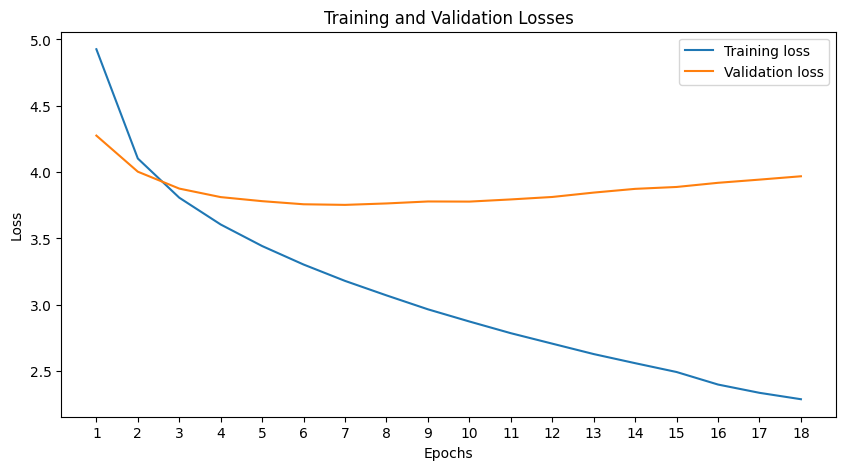

In [ ]:
#Edit x axis
import matplotlib.pyplot as plt

epochs = range(1, len(train_losses) + 1)

plt.figure(figsize=(10, 5))
plt.plot(epochs, train_losses, label='Training loss')
plt.plot(epochs, val_losses, label='Validation loss')
plt.title('Training and Validation Losses')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xticks(epochs)  # this line ensures the x-axis uses the values from the 'epochs' list
plt.legend()
plt.show()


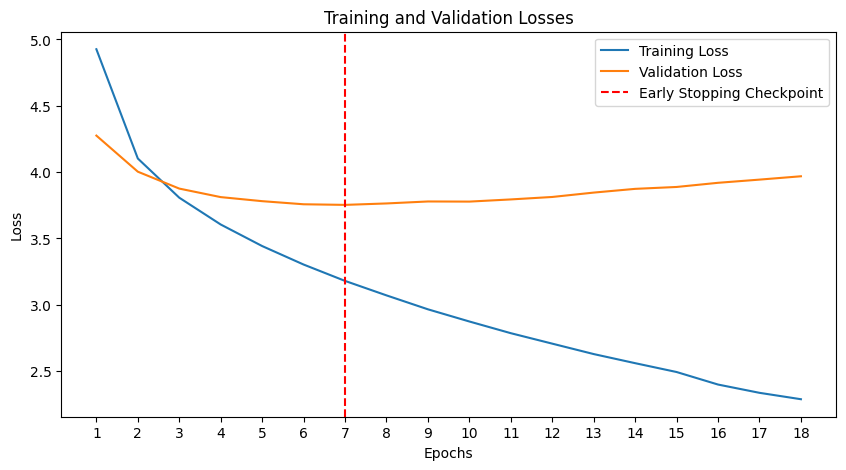

In [ ]:
# Edit x axis
import matplotlib.pyplot as plt

epochs = range(1, len(train_losses) + 1)
checkpoint = torch.load('BEST_checkpoint_caption_model_Fuse.pth.tar')
# stoppoint = checkpoint['epoch']
stoppoint = checkpoint['epoch']+1
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_losses, label='Training Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.title('Training and Validation Losses')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xticks(epochs)  # this line ensures the x-axis uses the values from the 'epochs' list
plt.legend()
plt.axvline(x=stoppoint, color='red', linestyle='--', label='Early Stopping Checkpoint')  # Adding the vertical line with a label
plt.legend()  # Call legend again to ensure the new label gets added
plt.show()


In [ ]:
import torch.nn.functional as F
def evaluate(beam_size,loader):
    """
    Evaluation
    :param beam_size: beam size at which to generate captions for evaluation
    :return: BLEU-4 score
    """
    # DataLoader


    # TODO: Batched Beam Search
    # Therefore, do not use a batch_size greater than 1 - IMPORTANT!

    # Lists to store references (true captions), and hypothesis (prediction) for each image
    # If for n images, we have n hypotheses, and references a, b, c... for each image, we need -
    # references = [[ref1a, ref1b, ref1c], [ref2a, ref2b], ...], hypotheses = [hyp1, hyp2, ...]
    references = list()
    hypotheses = list()

    # For each image
    for i, (image, caps, caplens, allcaps) in enumerate(
            tqdm(loader, desc="EVALUATING AT BEAM SIZE " + str(beam_size))):

        k = beam_size

        # Move to GPU device, if available
        image = image.to(device)  # (1, 3, 256, 256)

        # Encode
        encoder_out = encoder(image)  # (1, enc_image_size, enc_image_size, encoder_dim)
        enc_image_size = encoder_out.size(1)
        encoder_dim = encoder_out.size(3)

        # Flatten encoding
        encoder_out = encoder_out.view(1, -1, encoder_dim)  # (1, num_pixels, encoder_dim)
        num_pixels = encoder_out.size(1)

        # We'll treat the problem as having a batch size of k
        encoder_out = encoder_out.expand(k, num_pixels, encoder_dim)  # (k, num_pixels, encoder_dim)

        # Tensor to store top k previous words at each step; now they're just <start>
        k_prev_words = torch.LongTensor([[word_map['<start>']]] * k).to(device)  # (k, 1)

        # Tensor to store top k sequences; now they're just <start>
        seqs = k_prev_words  # (k, 1)

        # Tensor to store top k sequences' scores; now they're just 0
        top_k_scores = torch.zeros(k, 1).to(device)  # (k, 1)

        # Lists to store completed sequences and scores
        complete_seqs = list()
        complete_seqs_scores = list()

        # Start decoding
        step = 1
        h, c = decoder.init_hidden_state(encoder_out)

        # s is a number less than or equal to k, because sequences are removed from this process once they hit <end>
        while True:

            embeddings = decoder.embedding(k_prev_words).squeeze(1)  # (s, embed_dim)

            awe, _ = decoder.attention(encoder_out, h)  # (s, encoder_dim), (s, num_pixels)

            gate = decoder.sigmoid(decoder.f_beta(h))  # gating scalar, (s, encoder_dim)
            awe = gate * awe

            h, c = decoder.decode_step(torch.cat([embeddings, awe], dim=1), (h, c))  # (s, decoder_dim)

            scores = decoder.fc(h)  # (s, vocab_size)
            scores = F.log_softmax(scores, dim=1)

            # Add
            scores = top_k_scores.expand_as(scores) + scores  # (s, vocab_size)

            # For the first step, all k points will have the same scores (since same k previous words, h, c)
            if step == 1:
                top_k_scores, top_k_words = scores[0].topk(k, 0, True, True)  # (s)
            else:
                # Unroll and find top scores, and their unrolled indices
                top_k_scores, top_k_words = scores.view(-1).topk(k, 0, True, True)  # (s)

            # Convert unrolled indices to actual indices of scores
            vocab_size = len(word_map)+2
            prev_word_inds = top_k_words / vocab_size  # (s)
            next_word_inds = top_k_words % vocab_size  # (s)
            prev_word_inds = prev_word_inds.long()
#             print(prev_word_inds.dtype)
            # Add new words to sequences
            seqs = torch.cat([seqs[prev_word_inds], next_word_inds.unsqueeze(1)], dim=1)  # (s, step+1)

            # Which sequences are incomplete (didn't reach <end>)?
            incomplete_inds = [ind for ind, next_word in enumerate(next_word_inds) if
                               next_word != word_map['<end>']]
            complete_inds = list(set(range(len(next_word_inds))) - set(incomplete_inds))

            # Set aside complete sequences
            if len(complete_inds) > 0:
                complete_seqs.extend(seqs[complete_inds].tolist())
                complete_seqs_scores.extend(top_k_scores[complete_inds])
            k -= len(complete_inds)  # reduce beam length accordingly

            # Proceed with incomplete sequences
            if k == 0:
                break
            seqs = seqs[incomplete_inds]
            h = h[prev_word_inds[incomplete_inds]]
            c = c[prev_word_inds[incomplete_inds]]
            encoder_out = encoder_out[prev_word_inds[incomplete_inds]]
            top_k_scores = top_k_scores[incomplete_inds].unsqueeze(1)
            k_prev_words = next_word_inds[incomplete_inds].unsqueeze(1)

            # Break if things have been going on too long
            if step > 50:
                break
            step += 1
        try:

            i = complete_seqs_scores.index(max(complete_seqs_scores))
            seq = complete_seqs[i]
        except:
            i=0

        # References
        img_caps = allcaps[0].tolist()
        img_captions = list(
            map(lambda c: [w for w in c if w not in {word_map['<start>'], word_map['<end>'], word_map['<pad>']}],
                img_caps))  # remove <start> and pads
        references.append(img_captions)

        # Hypotheses
        hypotheses.append([w for w in seq if w not in {word_map['<start>'], word_map['<end>'], word_map['<pad>']}])

        assert len(references) == len(hypotheses)

    # Calculate BLEU scores
    bleu1 = corpus_bleu(references, hypotheses, weights=(1.0, 0, 0, 0))
    bleu2 = corpus_bleu(references, hypotheses, weights=(0.5, 0.5, 0, 0))
    bleu3 = corpus_bleu(references, hypotheses, weights=(0.33, 0.33, 0.33, 0))
    bleu4 = corpus_bleu(references, hypotheses, weights=(0.25, 0.25, 0.25, 0.25))

    bleu_scores = {"BLEU-1": bleu1, "BLEU-2": bleu2, "BLEU-3": bleu3, "BLEU-4": bleu4}

    return bleu_scores

In [ ]:
# for beam_size in range(1, 11):  # 1 to 10
#     bleu_scores = evaluate(beam_size,test_loader)
#     print("Beam size of %d" % (beam_size))
#     for key, score in bleu_scores.items():
#         print(f"{key}: {score*100:.2f}")
#     print()  # Print a newline for better readability


In [ ]:
import torch.nn.functional as F
from nltk.translate.meteor_score import meteor_score
from nltk.translate.bleu_score import corpus_bleu
def evaluate_BM(beam_size, loader, word_map):
    """
    Evaluation
    :param beam_size: beam size at which to generate captions for evaluation
    :return: BLEU-4 score
    """
    # DataLoader


    # TODO: Batched Beam Search
    # Therefore, do not use a batch_size greater than 1 - IMPORTANT!

    # Lists to store references (true captions), and hypothesis (prediction) for each image
    # If for n images, we have n hypotheses, and references a, b, c... for each image, we need -
    # references = [[ref1a, ref1b, ref1c], [ref2a, ref2b], ...], hypotheses = [hyp1, hyp2, ...]
    references = list()
    hypotheses = list()
    meteor_scores = list()

    # For each image
    for i, (image, caps, caplens, allcaps) in enumerate(
            tqdm(loader, desc="EVALUATING AT BEAM SIZE " + str(beam_size))):

        k = beam_size

        # Move to GPU device, if available
        image = image.to(device)  # (1, 3, 256, 256)

        # Encode
        encoder_out = encoder(image)  # (1, enc_image_size, enc_image_size, encoder_dim)
        enc_image_size = encoder_out.size(1)
        encoder_dim = encoder_out.size(3)

        # Flatten encoding
        encoder_out = encoder_out.view(1, -1, encoder_dim)  # (1, num_pixels, encoder_dim)
        num_pixels = encoder_out.size(1)

        # We'll treat the problem as having a batch size of k
        encoder_out = encoder_out.expand(k, num_pixels, encoder_dim)  # (k, num_pixels, encoder_dim)

        # Tensor to store top k previous words at each step; now they're just <start>
        k_prev_words = torch.LongTensor([[word_map['<start>']]] * k).to(device)  # (k, 1)

        # Tensor to store top k sequences; now they're just <start>
        seqs = k_prev_words  # (k, 1)

        # Tensor to store top k sequences' scores; now they're just 0
        top_k_scores = torch.zeros(k, 1).to(device)  # (k, 1)

        # Lists to store completed sequences and scores
        complete_seqs = list()
        complete_seqs_scores = list()

        # Start decoding
        step = 1
        h, c = decoder.init_hidden_state(encoder_out)

        # s is a number less than or equal to k, because sequences are removed from this process once they hit <end>
        while True:

            embeddings = decoder.embedding(k_prev_words).squeeze(1)  # (s, embed_dim)

            awe, _ = decoder.attention(encoder_out, h)  # (s, encoder_dim), (s, num_pixels)

            gate = decoder.sigmoid(decoder.f_beta(h))  # gating scalar, (s, encoder_dim)
            awe = gate * awe

            h, c = decoder.decode_step(torch.cat([embeddings, awe], dim=1), (h, c))  # (s, decoder_dim)

            scores = decoder.fc(h)  # (s, vocab_size)
            scores = F.log_softmax(scores, dim=1)

            # Add
            scores = top_k_scores.expand_as(scores) + scores  # (s, vocab_size)

            # For the first step, all k points will have the same scores (since same k previous words, h, c)
            if step == 1:
                top_k_scores, top_k_words = scores[0].topk(k, 0, True, True)  # (s)
            else:
                # Unroll and find top scores, and their unrolled indices
                top_k_scores, top_k_words = scores.view(-1).topk(k, 0, True, True)  # (s)

            # Convert unrolled indices to actual indices of scores
            vocab_size = len(word_map)+2
            prev_word_inds = top_k_words / vocab_size  # (s)
            next_word_inds = top_k_words % vocab_size  # (s)
            prev_word_inds = prev_word_inds.long()
#             print(prev_word_inds.dtype)
            # Add new words to sequences
            seqs = torch.cat([seqs[prev_word_inds], next_word_inds.unsqueeze(1)], dim=1)  # (s, step+1)

            # Which sequences are incomplete (didn't reach <end>)?
            incomplete_inds = [ind for ind, next_word in enumerate(next_word_inds) if
                               next_word != word_map['<end>']]
            complete_inds = list(set(range(len(next_word_inds))) - set(incomplete_inds))

            # Set aside complete sequences
            if len(complete_inds) > 0:
                complete_seqs.extend(seqs[complete_inds].tolist())
                complete_seqs_scores.extend(top_k_scores[complete_inds])
            k -= len(complete_inds)  # reduce beam length accordingly

            # Proceed with incomplete sequences
            if k == 0:
                break
            seqs = seqs[incomplete_inds]
            h = h[prev_word_inds[incomplete_inds]]
            c = c[prev_word_inds[incomplete_inds]]
            encoder_out = encoder_out[prev_word_inds[incomplete_inds]]
            top_k_scores = top_k_scores[incomplete_inds].unsqueeze(1)
            k_prev_words = next_word_inds[incomplete_inds].unsqueeze(1)

            # Break if things have been going on too long
            if step > 50:
                break
            step += 1
        try:

            i = complete_seqs_scores.index(max(complete_seqs_scores))
            seq = complete_seqs[i]
        except:
            i=0

        # References
        img_caps = allcaps[0].tolist()
        img_captions = list(
            map(lambda c: [w for w in c if w not in {word_map['<start>'], word_map['<end>'], word_map['<pad>']}],
                img_caps))  # remove <start> and pads
        references.append(img_captions)

        # Hypotheses
        hypotheses.append([w for w in seq if w not in {word_map['<start>'], word_map['<end>'], word_map['<pad>']}])

        assert len(references) == len(hypotheses)

    # Calculate BLEU scores
    bleu1 = corpus_bleu(references, hypotheses, weights=(1.0, 0, 0, 0))
    bleu2 = corpus_bleu(references, hypotheses, weights=(0.5, 0.5, 0, 0))
    bleu3 = corpus_bleu(references, hypotheses, weights=(0.33, 0.33, 0.33, 0))
    bleu4 = corpus_bleu(references, hypotheses, weights=(0.25, 0.25, 0.25, 0.25))

    bleu_scores = {"BLEU-1": bleu1, "BLEU-2": bleu2, "BLEU-3": bleu3, "BLEU-4": bleu4}

    # METEOR score calculation
    id_to_word = {id: word for word, id in word_map.items()}
    for refs, hyp in zip(references, hypotheses):
        tokenized_refs = [[id_to_word[id] for id in ref if id in id_to_word] for ref in refs]
        tokenized_hyp = [id_to_word[id] for id in hyp if id in id_to_word]
        score = meteor_score(tokenized_refs, tokenized_hyp)
        meteor_scores.append(score)

    avg_meteor = sum(meteor_scores) / len(meteor_scores) if meteor_scores else 0

    return bleu_scores, avg_meteor

**Load Model and Evaluate**

In [ ]:
import nltk
nltk.download('wordnet')
# Load best checkpoint
checkpoint = torch.load('BEST_checkpoint_caption_model_Fuse.pth.tar')
encoder.load_state_dict(checkpoint['encoder_state_dict'])
decoder.load_state_dict(checkpoint['decoder_state_dict'])

# Print epoch number of the best checkpoint
print("Best model found at epoch:", checkpoint['epoch'])

encoder.eval()
decoder.eval()

# Initialize lists to store BLEU-4 and METEOR scores
bleu_4_scores_list = []
meteor_scores_list = []

for beam_size in range(1, 11):  # 1 to 10
    bleu_scores, avg_meteor = evaluate_BM(beam_size, test_loader, word_map)  # Unpack the returned tuple

    # Extract the BLEU-4 score and multiply by 100 to convert to percentage
    bleu_4_score = bleu_scores["BLEU-4"] * 100
    # Multiply the METEOR score by 100 to convert to percentage
    avg_meteor_score = avg_meteor * 100

    # Store the scores in their respective lists
    bleu_4_scores_list.append(bleu_4_score)
    meteor_scores_list.append(avg_meteor_score)

    print("Beam size of %d" % beam_size)
    for key, score in bleu_scores.items():
        print(f"{key}: {score*100:.2f}")
    print("Meteor: {:.2f}".format(avg_meteor * 100))  # Print the average METEOR score

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Best model found at epoch: 6


EVALUATING AT BEAM SIZE 1: 100%|██████████| 5000/5000 [05:36<00:00, 14.86it/s]


Beam size of 1
BLEU-1: 62.46
BLEU-2: 42.58
BLEU-3: 29.47
BLEU-4: 19.85
Meteor: 44.34


EVALUATING AT BEAM SIZE 2: 100%|██████████| 5000/5000 [05:57<00:00, 13.98it/s]


Beam size of 2
BLEU-1: 65.90
BLEU-2: 45.75
BLEU-3: 32.81
BLEU-4: 22.99
Meteor: 44.98


EVALUATING AT BEAM SIZE 3: 100%|██████████| 5000/5000 [06:05<00:00, 13.69it/s]


Beam size of 3
BLEU-1: 66.89
BLEU-2: 46.35
BLEU-3: 33.35
BLEU-4: 23.39
Meteor: 44.72


EVALUATING AT BEAM SIZE 4: 100%|██████████| 5000/5000 [06:23<00:00, 13.04it/s]


Beam size of 4
BLEU-1: 68.18
BLEU-2: 47.66
BLEU-3: 34.46
BLEU-4: 24.37
Meteor: 45.16


EVALUATING AT BEAM SIZE 5: 100%|██████████| 5000/5000 [06:42<00:00, 12.44it/s]


Beam size of 5
BLEU-1: 68.50
BLEU-2: 47.87
BLEU-3: 34.63
BLEU-4: 24.53
Meteor: 44.76


EVALUATING AT BEAM SIZE 6: 100%|██████████| 5000/5000 [07:00<00:00, 11.89it/s]


Beam size of 6
BLEU-1: 68.02
BLEU-2: 47.55
BLEU-3: 34.23
BLEU-4: 24.17
Meteor: 44.91


EVALUATING AT BEAM SIZE 7: 100%|██████████| 5000/5000 [07:15<00:00, 11.47it/s]


Beam size of 7
BLEU-1: 68.01
BLEU-2: 47.58
BLEU-3: 34.32
BLEU-4: 24.25
Meteor: 44.84


EVALUATING AT BEAM SIZE 8: 100%|██████████| 5000/5000 [07:34<00:00, 11.01it/s]


Beam size of 8
BLEU-1: 67.73
BLEU-2: 47.34
BLEU-3: 34.18
BLEU-4: 24.15
Meteor: 44.64


EVALUATING AT BEAM SIZE 9: 100%|██████████| 5000/5000 [07:44<00:00, 10.76it/s]


Beam size of 9
BLEU-1: 67.54
BLEU-2: 47.19
BLEU-3: 33.89
BLEU-4: 23.76
Meteor: 44.52


EVALUATING AT BEAM SIZE 10: 100%|██████████| 5000/5000 [08:02<00:00, 10.36it/s]


Beam size of 10
BLEU-1: 67.57
BLEU-2: 47.34
BLEU-3: 34.10
BLEU-4: 24.02
Meteor: 44.48


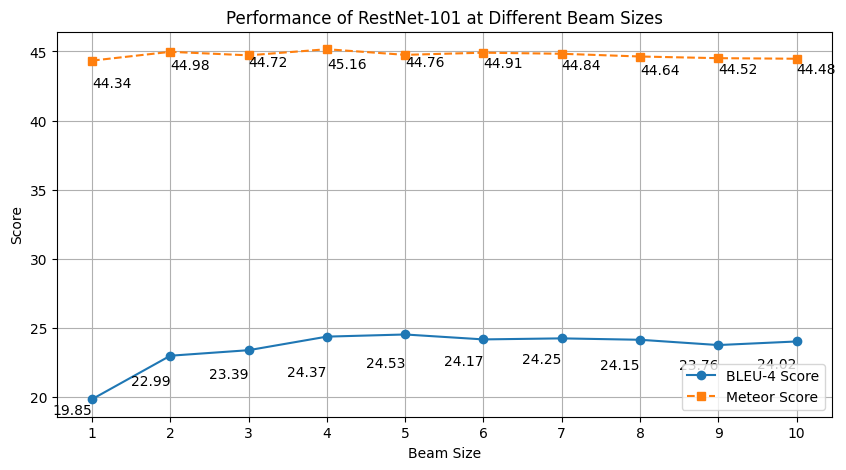

In [ ]:
import matplotlib.pyplot as plt

# Beam sizes
beam_sizes = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

# BLEU-4 scores
bleu_4_scores = [18.50, 20.63, 21.14, 21.26, 21.93, 22.10, 22.20, 21.79, 21.77, 21.87]

# Meteor scores, scaled to match the range of BLEU-4 for visualization
meteor_scores = [43.22, 44.48, 44.75, 44.56, 44.74, 44.64, 44.48, 44.13, 44.21, 44.20]

# bleu_4_scores_list = []
# meteor_scores_list = []

# Plotting both the BLEU-4 and Meteor scores
plt.figure(figsize=(10, 5))
bleu_line, = plt.plot(beam_sizes, bleu_4_scores_list, marker='o', label='BLEU-4 Score')
meteor_line, = plt.plot(beam_sizes, meteor_scores_list, marker='s', linestyle='--', label='Meteor Score')

# Adding the legend
plt.legend()

# Titles and labels
plt.title('Performance of RestNet-101 at Different Beam Sizes')
plt.xlabel('Beam Size')
plt.ylabel('Score')

# Adjusting x-axis to show each beam size
plt.xticks(beam_sizes)

# Show grid
plt.grid(True)

# Displaying values at each point for BLEU-4
for i, txt in enumerate(bleu_4_scores_list):
    plt.text(beam_sizes[i], bleu_4_scores[i], f"{txt:.2f}", ha='right', va='bottom')

# Displaying values at each point for Meteor
for i, txt in enumerate(meteor_scores_list):
    plt.text(beam_sizes[i], meteor_scores[i], f"{txt:.2f}", ha='left', va='top')

# Show the plot
plt.show()

# FLOPS and Params

In [ ]:
!pip install ptflops

In [ ]:
print(encoder)  # Or whichever model you're using
for param in encoder.parameters():
    print(param.size())


Encoder(
  (resnet_model): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Conv2d

In [ ]:
import torch
from ptflops import get_model_complexity_info

# Assuming 'encoder' is your model and already defined

# Unfreeze all parameters for training
for param in encoder.parameters():
    param.requires_grad = True

# Move the model to the appropriate device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
encoder = encoder.to(device)

# Ensure the model is in evaluation mode if it includes any batch normalization or dropout layers
encoder.eval()

# Now run the complexity analysis with an input resolution of 3x224x224
flops, params = get_model_complexity_info(encoder, (3, 224, 224), as_strings=True,
                                          print_per_layer_stat=True, verbose=True)

print(f"FLOPs: {flops}")
print(f"Params: {params}")

# Additionally, print the manual parameter count for verification
total_params = sum(p.numel() for p in encoder.parameters() if p.requires_grad)
print(f"Manual parameter count: {total_params} Parameters")


Encoder(
  43.82 M, 91.702% Params, 7.86 GMac, 99.772% MACs, 
  (resnet_model): Sequential(
    42.5 M, 88.933% Params, 7.85 GMac, 99.598% MACs, 
    (0): Conv2d(9.41 k, 0.020% Params, 118.01 MMac, 1.498% MACs, 3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(128, 0.000% Params, 1.61 MMac, 0.020% MACs, 64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(0, 0.000% Params, 802.82 KMac, 0.010% MACs, inplace=True)
    (3): MaxPool2d(0, 0.000% Params, 802.82 KMac, 0.010% MACs, kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      215.81 k, 0.452% Params, 680.39 MMac, 8.635% MACs, 
      (0): Bottleneck(
        75.01 k, 0.157% Params, 236.43 MMac, 3.001% MACs, 
        (conv1): Conv2d(4.1 k, 0.009% Params, 12.85 MMac, 0.163% MACs, 64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(128, 0.000% Params, 401.41 KMac, 0.005% MACs, 64, eps=1e-05, momentum=0.

# Image Sample

In [ ]:
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
def evaluate_print_image(beam_size,loader):
    """
    Evaluation
    :param beam_size: beam size at which to generate captions for evaluation
    :return: BLEU-4 score
    """
    # DataLoader


    # TODO: Batched Beam Search
    # Therefore, do not use a batch_size greater than 1 - IMPORTANT!

    # Lists to store references (true captions), and hypothesis (prediction) for each image
    # If for n images, we have n hypotheses, and references a, b, c... for each image, we need -
    # references = [[ref1a, ref1b, ref1c], [ref2a, ref2b], ...], hypotheses = [hyp1, hyp2, ...]

    # Define the indices you are interested in
    target_indices = [85, 205, 410, 560, 785, 995, 1225, 1480, 1725, 1995, 2245, 2495, 2750, 3005, 3220, 3475, 3725, 3980, 4210, 4495]



    references = list()
    hypotheses = list()

    # For each image
    for i, (image, caps, caplens, allcaps) in enumerate(
        tqdm(loader, desc="EVALUATING AT BEAM SIZE " + str(beam_size))):
        image_index = i
        k = beam_size

        # Move to GPU device, if available
        image = image.to(device)  # (1, 3, 256, 256)

        # Encode
        encoder_out = encoder(image)  # (1, enc_image_size, enc_image_size, encoder_dim)
        enc_image_size = encoder_out.size(1)
        encoder_dim = encoder_out.size(3)

        # Flatten encoding
        encoder_out = encoder_out.view(1, -1, encoder_dim)  # (1, num_pixels, encoder_dim)
        num_pixels = encoder_out.size(1)

        # We'll treat the problem as having a batch size of k
        encoder_out = encoder_out.expand(k, num_pixels, encoder_dim)  # (k, num_pixels, encoder_dim)

        # Tensor to store top k previous words at each step; now they're just <start>
        k_prev_words = torch.LongTensor([[word_map['<start>']]] * k).to(device)  # (k, 1)

        # Tensor to store top k sequences; now they're just <start>
        seqs = k_prev_words  # (k, 1)

        # Tensor to store top k sequences' scores; now they're just 0
        top_k_scores = torch.zeros(k, 1).to(device)  # (k, 1)

        # Lists to store completed sequences and scores
        complete_seqs = list()
        complete_seqs_scores = list()

        # Start decoding
        step = 1
        h, c = decoder.init_hidden_state(encoder_out)

        # s is a number less than or equal to k, because sequences are removed from this process once they hit <end>
        while True:

            embeddings = decoder.embedding(k_prev_words).squeeze(1)  # (s, embed_dim)

            awe, _ = decoder.attention(encoder_out, h)  # (s, encoder_dim), (s, num_pixels)

            gate = decoder.sigmoid(decoder.f_beta(h))  # gating scalar, (s, encoder_dim)
            awe = gate * awe

            h, c = decoder.decode_step(torch.cat([embeddings, awe], dim=1), (h, c))  # (s, decoder_dim)

            scores = decoder.fc(h)  # (s, vocab_size)
            scores = F.log_softmax(scores, dim=1)

            # Add
            scores = top_k_scores.expand_as(scores) + scores  # (s, vocab_size)

            # For the first step, all k points will have the same scores (since same k previous words, h, c)
            if step == 1:
                top_k_scores, top_k_words = scores[0].topk(k, 0, True, True)  # (s)
            else:
                # Unroll and find top scores, and their unrolled indices
                top_k_scores, top_k_words = scores.view(-1).topk(k, 0, True, True)  # (s)

            # Convert unrolled indices to actual indices of scores
            vocab_size = len(word_map)+2
            prev_word_inds = top_k_words / vocab_size  # (s)
            next_word_inds = top_k_words % vocab_size  # (s)
            prev_word_inds = prev_word_inds.long()
#             print(prev_word_inds.dtype)
            # Add new words to sequences
            seqs = torch.cat([seqs[prev_word_inds], next_word_inds.unsqueeze(1)], dim=1)  # (s, step+1)

            # Which sequences are incomplete (didn't reach <end>)?
            incomplete_inds = [ind for ind, next_word in enumerate(next_word_inds) if
                               next_word != word_map['<end>']]
            complete_inds = list(set(range(len(next_word_inds))) - set(incomplete_inds))

            # Set aside complete sequences
            if len(complete_inds) > 0:
                complete_seqs.extend(seqs[complete_inds].tolist())
                complete_seqs_scores.extend(top_k_scores[complete_inds])
            k -= len(complete_inds)  # reduce beam length accordingly

            # Proceed with incomplete sequences
            if k == 0:
                break
            seqs = seqs[incomplete_inds]
            h = h[prev_word_inds[incomplete_inds]]
            c = c[prev_word_inds[incomplete_inds]]
            encoder_out = encoder_out[prev_word_inds[incomplete_inds]]
            top_k_scores = top_k_scores[incomplete_inds].unsqueeze(1)
            k_prev_words = next_word_inds[incomplete_inds].unsqueeze(1)

            # Break if things have been going on too long
            if step > 50:
                break
            step += 1
        try:

            max_index = complete_seqs_scores.index(max(complete_seqs_scores)) # use a different variable name
            seq = complete_seqs[max_index]
        except:
            max_index = 0  # use a different variable name


        # References
        img_caps = allcaps[0].tolist()
        img_captions = list(
            map(lambda c: [w for w in c if w not in {word_map['<start>'], word_map['<end>'], word_map['<pad>']}],
                img_caps))  # remove <start> and pads
        references.append(img_captions)

        # Hypotheses
        hypotheses.append([w for w in seq if w not in {word_map['<start>'], word_map['<end>'], word_map['<pad>']}])

        assert len(references) == len(hypotheses)

        inv_word_map = {v: k for k, v in word_map.items()}

        if i in target_indices:
            print(f"Processing image index: {i}")
            # Convert IDs to words
            references_word = [[inv_word_map[id] for id in ref] for ref in img_captions]
            hypotheses_word = [inv_word_map[id] for id in hypotheses[-1]]  # hypotheses[-1] is the hypothesis for the current image

            # Print them
            print(f"For image index {i}:")
            print("References:")
            for ref in references_word:
                print(' '.join(ref))
            print("Hypotheses:")
            print(' '.join(hypotheses_word))

            # Mean and standard deviation used for the initial normalization
            mean = np.array([0.485, 0.456, 0.406])
            std = np.array([0.229, 0.224, 0.225])

            # Reverse the normalization
            image = image.squeeze(0)  # Remove the batch dimension if present
            image = image.cpu().numpy()  # Convert to numpy
            image = np.transpose(image, (1, 2, 0))  # Change from (C, H, W) to (H, W, C)
            image = image * std + mean  # Reverse normalization
            image = np.clip(image, 0, 1)  # Ensure the image is between 0 and 1

            # Display the image
            plt.imshow(image)
            plt.show()

            # Calculate BLEU scores for this image
            bleu1 = corpus_bleu([img_captions], [hypotheses[-1]], weights=(1.0, 0, 0, 0))
            bleu2 = corpus_bleu([img_captions], [hypotheses[-1]], weights=(0.5, 0.5, 0, 0))
            bleu3 = corpus_bleu([img_captions], [hypotheses[-1]], weights=(0.33, 0.33, 0.33, 0))
            bleu4 = corpus_bleu([img_captions], [hypotheses[-1]], weights=(0.25, 0.25, 0.25, 0.25))

            print(f"For image index {i}, BLEU scores are: BLEU-1: {bleu1}, BLEU-2: {bleu2}, BLEU-3: {bleu3}, BLEU-4: {bleu4}")

    # Calculate BLEU scores
    bleu1 = corpus_bleu(references, hypotheses, weights=(1.0, 0, 0, 0))
    bleu2 = corpus_bleu(references, hypotheses, weights=(0.5, 0.5, 0, 0))
    bleu3 = corpus_bleu(references, hypotheses, weights=(0.33, 0.33, 0.33, 0))
    bleu4 = corpus_bleu(references, hypotheses, weights=(0.25, 0.25, 0.25, 0.25))
    bleu_scores = {"BLEU-1": bleu1, "BLEU-2": bleu2, "BLEU-3": bleu3, "BLEU-4": bleu4}

    return bleu_scores

In [ ]:
from torch.utils.data import DataLoader

# Assuming 'test_data' is already defined
test_loader_new = DataLoader(test_data, batch_size=1, shuffle=False, pin_memory=True)

# Looping through beam sizes from 1 to 10
for beam_size in range(1, 11):
    bleu_scores = evaluate_print_image(beam_size, test_loader_new)
    print("Beam size of %d" % (beam_size))
    for key, score in bleu_scores.items():
        print(f"{key}: {score*100:.2f}%")
    print("\n")  # Adds a newline for better readability between each beam size's output


NameError: name 'test_data' is not defined